## Introduction

In this Jupyter Notebook, we dive deep into the analysis of user behavior, conversion rates, and landing page variants for Bluetooth speaker sales. From hypothesis testing to multivariate analysis, sequential testing, and Bayesian methods, we explore how different factors like demographics, device type, and session engagement impact conversions. We also evaluate revenue trends and the effectiveness of marketing strategies, providing actionable insights to optimize performance. Let’s explore and drive better business decisions together!


## Import Required Libraries


In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import warnings

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportion_effectsize, proportions_ztest
from statsmodels.stats.power import NormalIndPower

# Statistical Tests
from scipy.stats import chi2_contingency, ttest_ind, f_oneway, stats

# Pretty Print
from pprint import pprint

# Ignore Warnings
warnings.filterwarnings("ignore")


    
## Cleaning, Preprocessing, EDA



In [2]:
# Load Data
df = pd.read_csv("/kaggle/input/bassburst/cleaned_speakers_data.csv")

# Data Cleaning & Preprocessing
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Print data info
print("=== Data Info ===")
pprint(df.info())

# Print descriptive statistics
print("\n=== Descriptive Statistics ===")
pprint(df.describe(include='all'))

# Print missing values
print("\n=== Missing Values ===")
pprint(df.isnull().sum())

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                30000 non-null  object        
 1   session_id             30000 non-null  object        
 2   sign_in                30000 non-null  object        
 3   name                   30000 non-null  object        
 4   demographic_age        30000 non-null  int64         
 5   demographic_age_group  30000 non-null  object        
 6   demographic_gender     30000 non-null  object        
 7   email                  30000 non-null  object        
 8   location               30000 non-null  object        
 9   country                30000 non-null  object        
 10  device_type            30000 non-null  object        
 11  timestamp              30000 non-null  datetime64[ns]
 12  variant_group          30000 non-null  obj

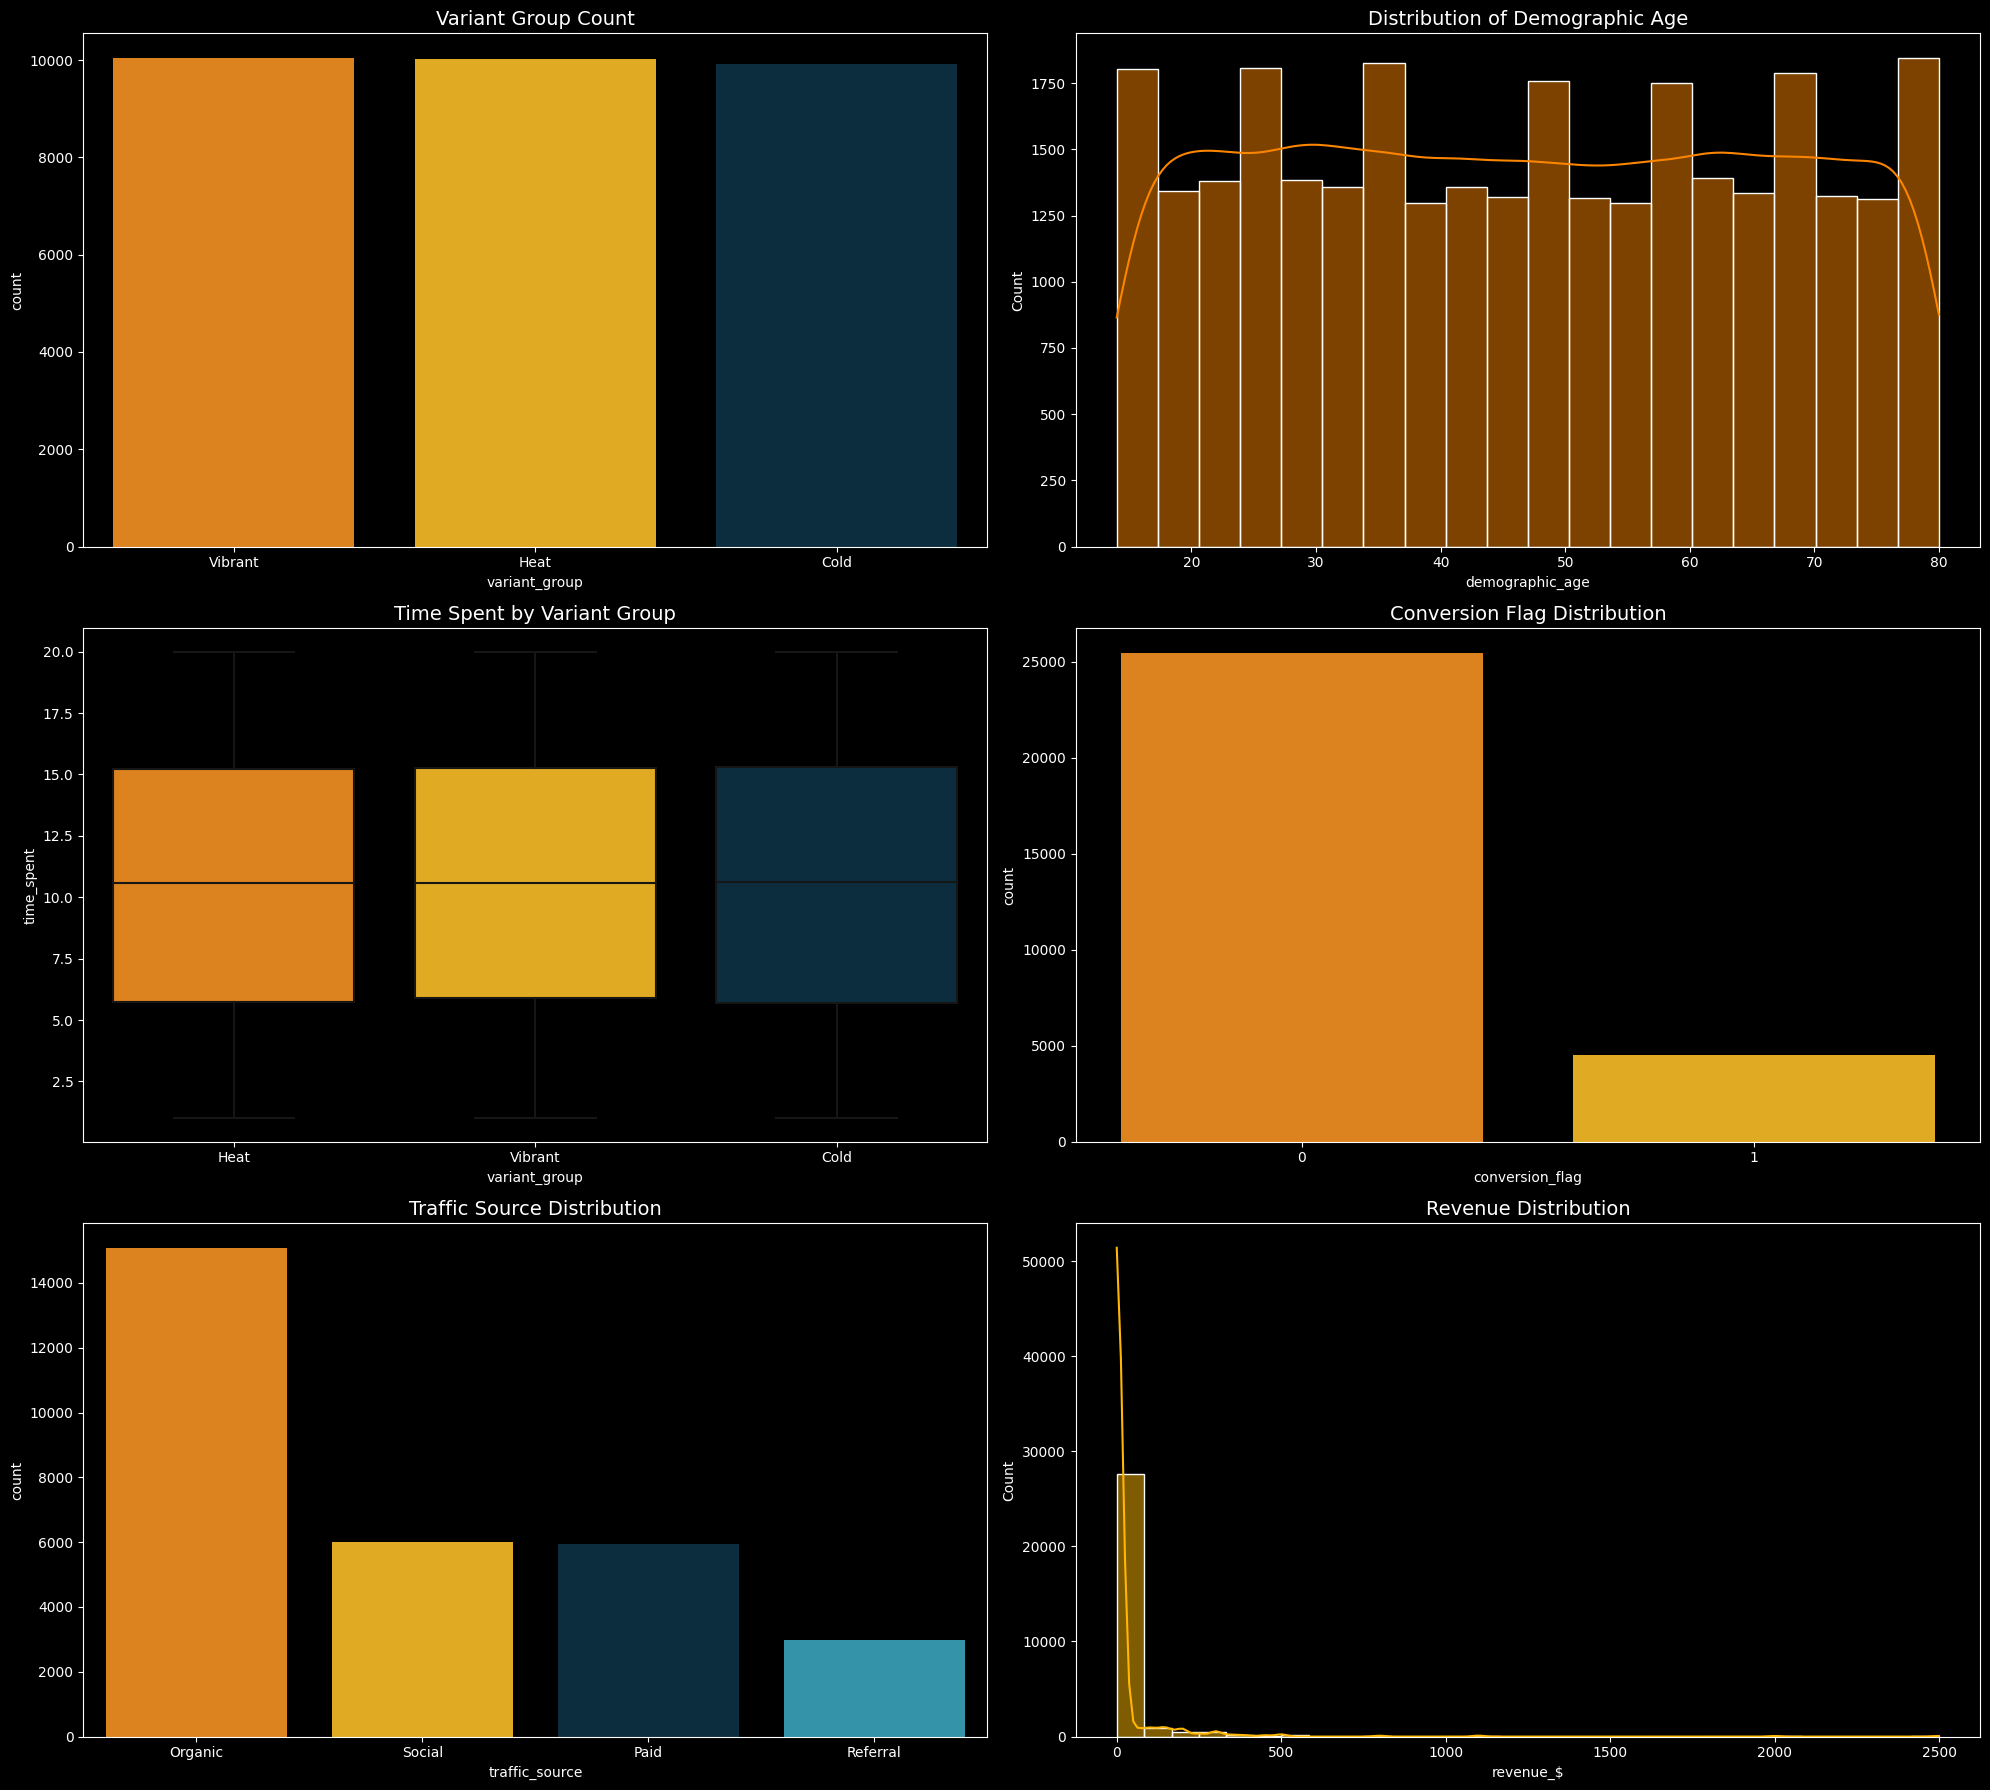

In [3]:
# Your color palette
color_palette = ['#FB8500', '#FFB703', '#023047', '#219EBC', '#8ECAE6']

# Set the color palette
sns.set_palette(color_palette)

# Set the style to have a black background
plt.style.use('dark_background')

# Create a figure with subplots arranged in a grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 18))  # 3 rows, 2 columns
fig.patch.set_facecolor('black')  # Set the background color of the figure

# Plot 1: Variant Group Count
sns.countplot(data=df, x='variant_group', order=df['variant_group'].value_counts().index, palette=color_palette, ax=axes[0, 0])
axes[0, 0].set_title("Variant Group Count", fontsize=14)

# Plot 2: Distribution of Demographic Age
sns.histplot(df['demographic_age'], bins=20, kde=True, color=color_palette[0], ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Demographic Age", fontsize=14)

# Plot 3: Time Spent by Variant Group
sns.boxplot(x='variant_group', y='time_spent', data=df, palette=color_palette, ax=axes[1, 0])
axes[1, 0].set_title("Time Spent by Variant Group", fontsize=14)

# Plot 4: Conversion Flag Distribution
sns.countplot(data=df, x='conversion_flag', palette=color_palette, ax=axes[1, 1])
axes[1, 1].set_title("Conversion Flag Distribution", fontsize=14)

# Plot 5: Traffic Source Distribution
sns.countplot(data=df, x='traffic_source', order=df['traffic_source'].value_counts().index, palette=color_palette, ax=axes[2, 0])
axes[2, 0].set_title("Traffic Source Distribution", fontsize=14)

# Plot 6: Revenue Distribution
sns.histplot(df['revenue_$'], bins=30, kde=True, color=color_palette[1], ax=axes[2, 1])
axes[2, 1].set_title("Revenue Distribution", fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



    
## Bounce Flag Analysis


| **🧶Bounce Flag**                                                                 |
|--------------------------------------------------------------------------------|
| This flag indicates whether a visitor **"bounced"** from the page, that is, whether they left the site after viewing only one page (or with minimal interaction). |

| **🧶Key Points**                                                                 |
|--------------------------------------------------------------------------------|
| - **1**: The visitor bounced, implying a very low engagement (e.g., they visited only one page and then left). |
| - **0**: The visitor did not bounce, suggesting they engaged further with the site (viewed more than one page). |

| **🧶Interpretation**                                                             |
|--------------------------------------------------------------------------------|
| A high bounce rate might signal issues with **user engagement** or **content relevance**, whereas a lower bounce rate suggests that visitors are interacting more with your site. |

| **🧶Tip**                                                                        |
|--------------------------------------------------------------------------------|
| Analyze bounce rates regularly to improve user engagement and content relevance. |

In [4]:
# Bounce Flag Distribution
bounce_count = df['bounce_flag'].sum()
total_sessions = df.shape[0]
bounce_rate = bounce_count / total_sessions
pprint({
    "Total Sessions": total_sessions,
    "Total Bounces": bounce_count,
    "Bounce Rate": bounce_rate
})

{'Bounce Rate': 0.18906666666666666,
 'Total Bounces': 5672,
 'Total Sessions': 30000}


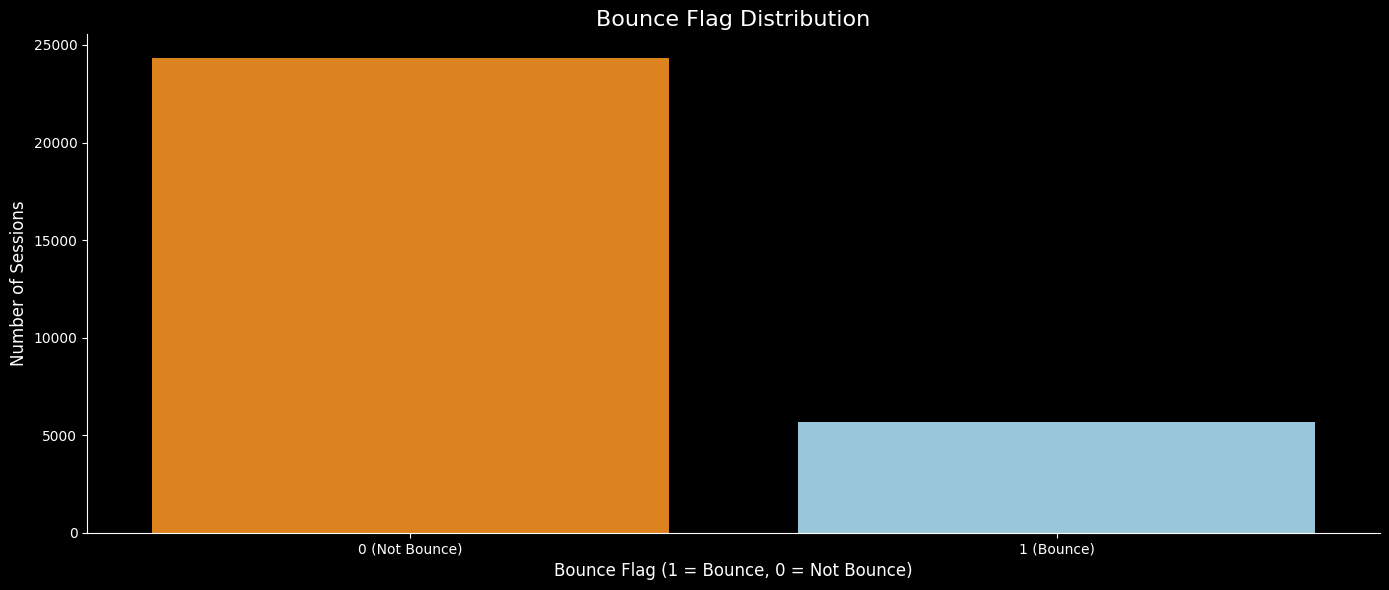

In [5]:
# Set the style to have a black background
plt.style.use('dark_background')

# Create the count plot using Seaborn with a larger figure size
plt.figure(figsize=(14, 6))  # Increase width to 14 (or as needed) for full-page display
sns.countplot(
    data=df, 
    x='bounce_flag', 
    palette=['#FB8500', '#8ECAE6'],  # Custom colors for 0 and 1
)

# Customize the plot
plt.title("Bounce Flag Distribution", fontsize=16, color='white')
plt.xlabel("Bounce Flag (1 = Bounce, 0 = Not Bounce)", fontsize=12, color='white')
plt.ylabel("Number of Sessions", fontsize=12, color='white')
plt.xticks(ticks=[0, 1], labels=["0 (Not Bounce)", "1 (Bounce)"], color='white')
plt.yticks(color='white')

# Set black background
plt.gca().set_facecolor('black')  # Background of the plot
plt.gcf().set_facecolor('black')  # Background of the figure

# Remove spines (optional)
sns.despine()

# Adjust layout to fit the plot within the cell
plt.tight_layout()

# Show the plot
plt.show()

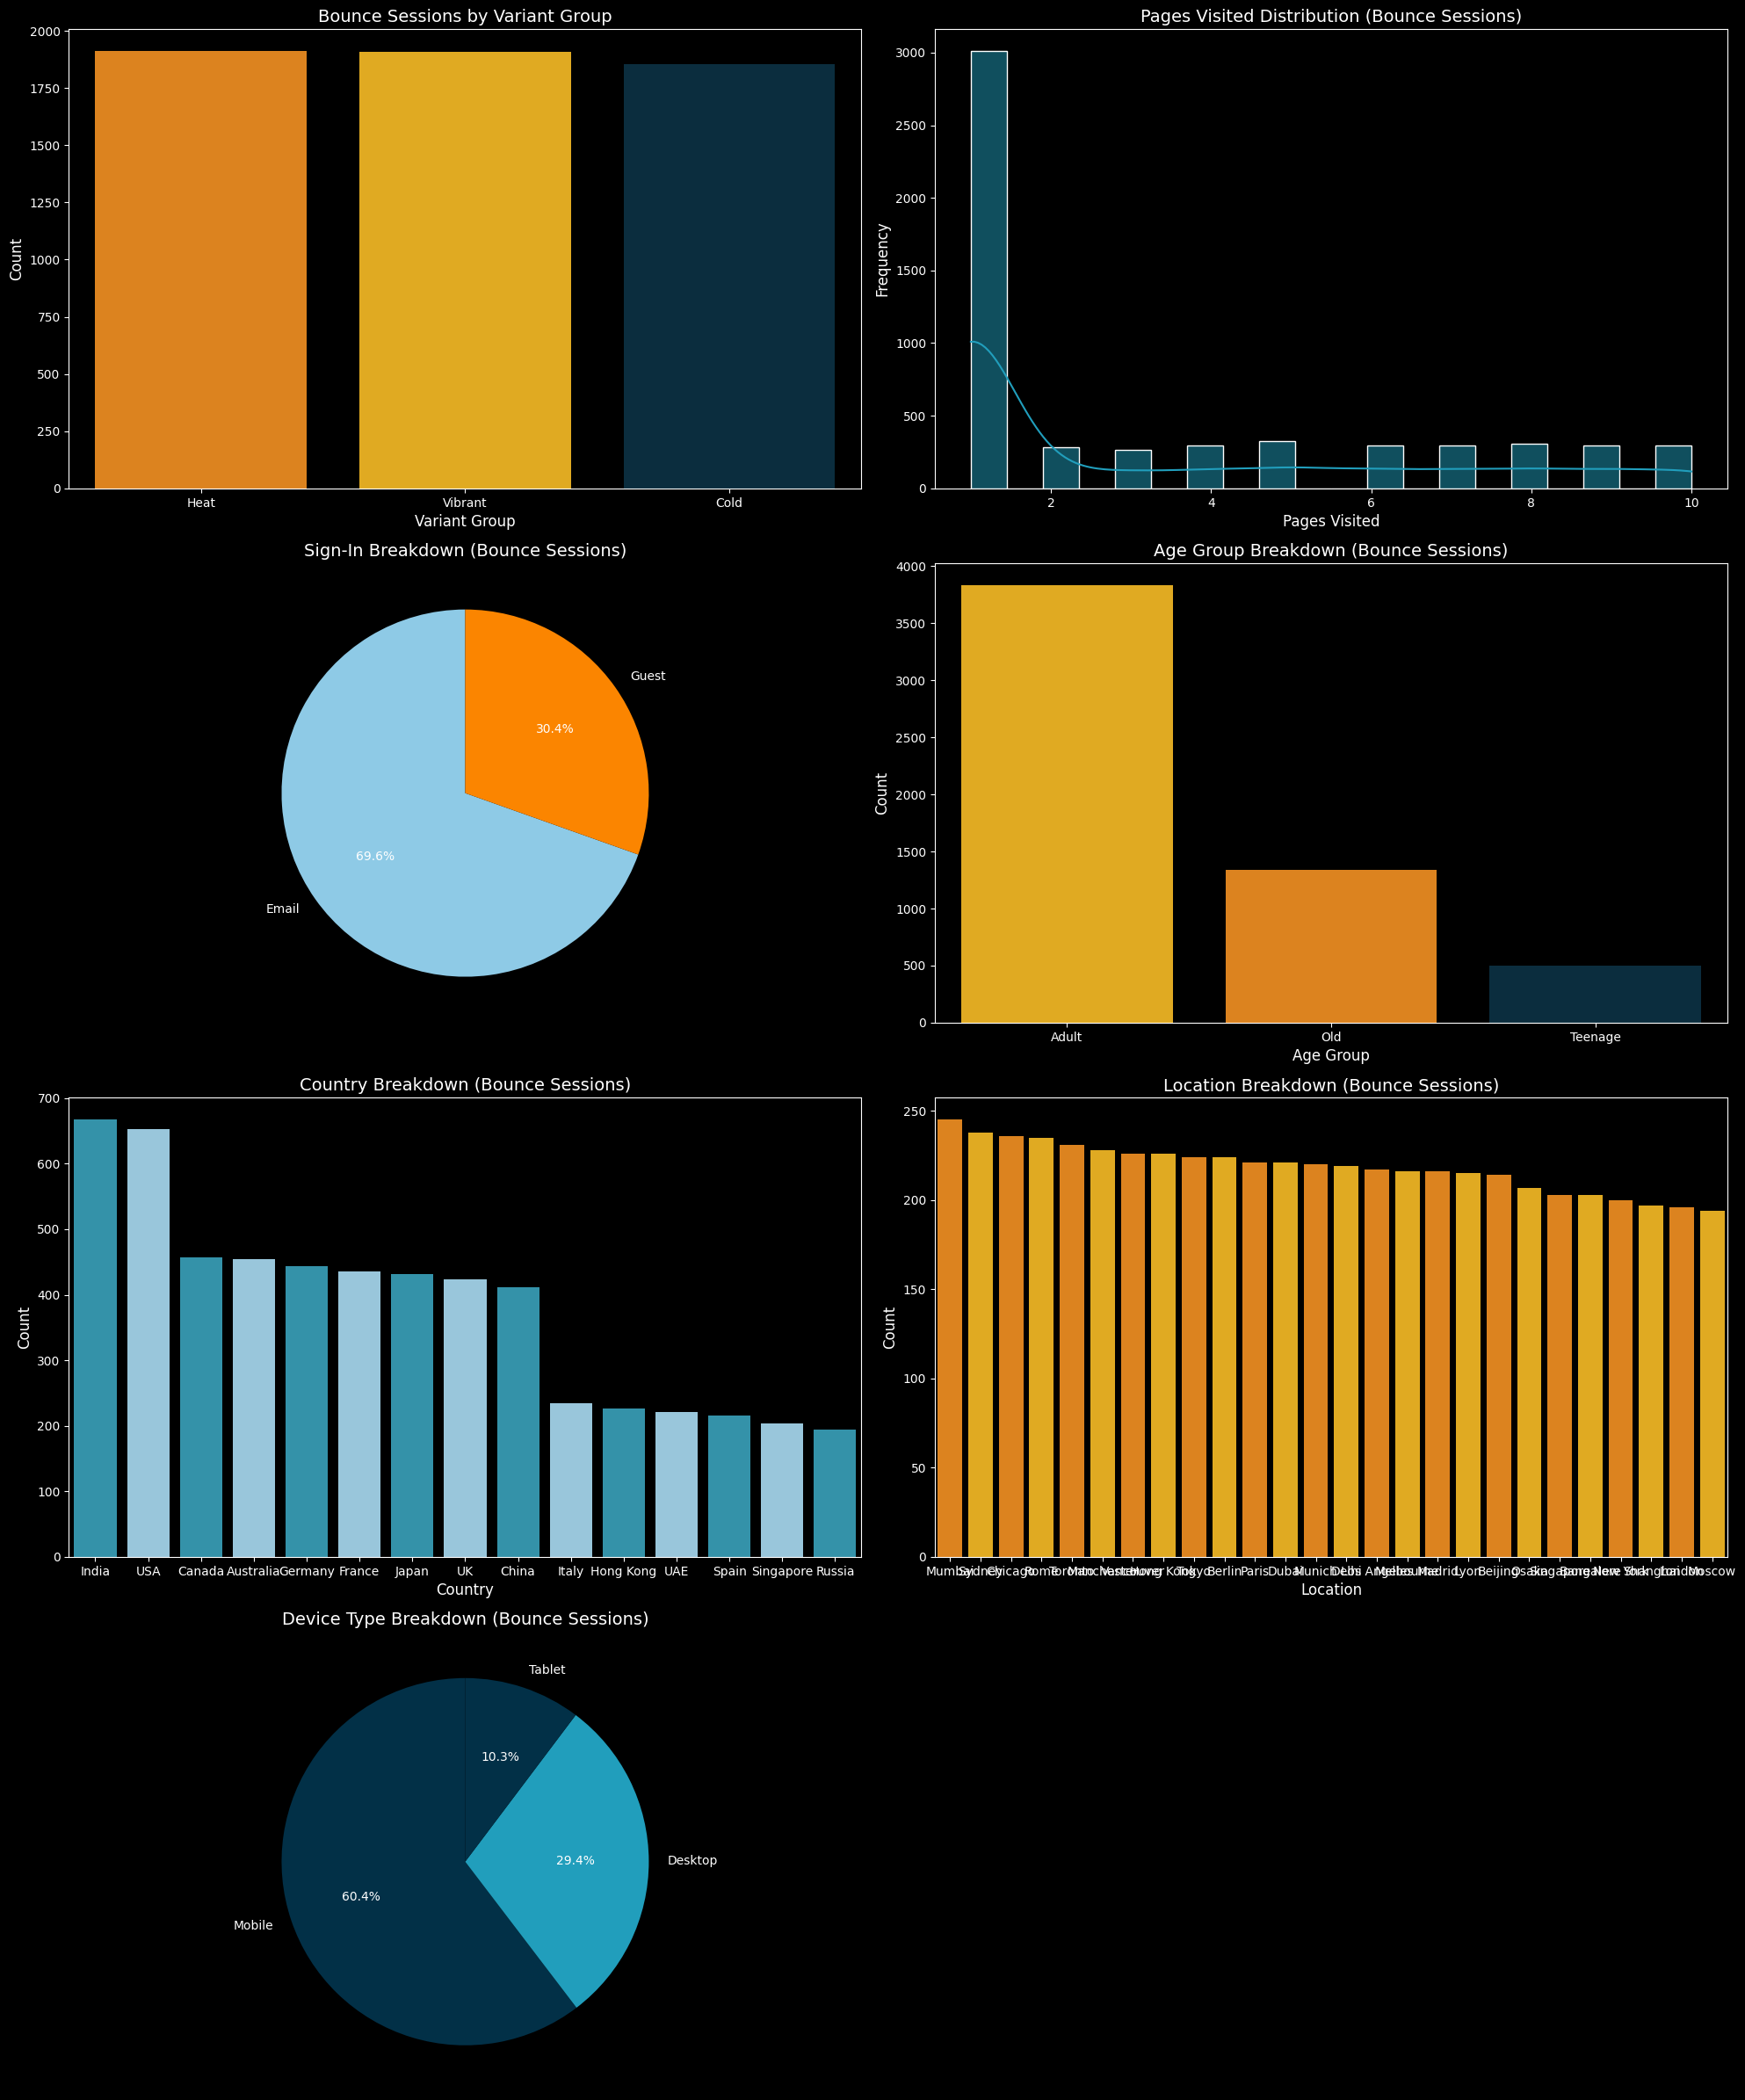

In [6]:
# Filter bounce sessions
bounce_df = df[df['bounce_flag'] == 1]

# Set the style to have a black background
plt.style.use('dark_background')

# Create a subplot grid
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 24))
fig.patch.set_facecolor('black')  # Set the background color of the figure

# 1. Variant Group with maximum bounce sessions
variant_bounce_counts = bounce_df['variant_group'].value_counts()
sns.barplot(x=variant_bounce_counts.index, y=variant_bounce_counts.values, palette=['#FB8500', '#FFB703', '#023047'], ax=axes[0, 0])
axes[0, 0].set_title("Bounce Sessions by Variant Group", fontsize=14, color='white')
axes[0, 0].set_xlabel("Variant Group", fontsize=12, color='white')
axes[0, 0].set_ylabel("Count", fontsize=12, color='white')

# 2. Pages Visited Distribution
sns.histplot(bounce_df['pages_visited'], bins=20, color='#219EBC', kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Pages Visited Distribution (Bounce Sessions)", fontsize=14, color='white')
axes[0, 1].set_xlabel("Pages Visited", fontsize=12, color='white')
axes[0, 1].set_ylabel("Frequency", fontsize=12, color='white')

# 3. Sign-In Breakdown
sign_in_bounce = bounce_df['sign_in'].value_counts()
axes[1, 0].pie(sign_in_bounce.values, labels=sign_in_bounce.index, colors=['#8ECAE6', '#FB8500'], autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title("Sign-In Breakdown (Bounce Sessions)", fontsize=14, color='white')

# 4. Age Group Breakdown
age_group_bounce = bounce_df['demographic_age_group'].value_counts()
sns.barplot(x=age_group_bounce.index, y=age_group_bounce.values, palette=['#FFB703', '#FB8500', '#023047'], ax=axes[1, 1])
axes[1, 1].set_title("Age Group Breakdown (Bounce Sessions)", fontsize=14, color='white')
axes[1, 1].set_xlabel("Age Group", fontsize=12, color='white')
axes[1, 1].set_ylabel("Count", fontsize=12, color='white')

# 5. Country Breakdown
country_bounce = bounce_df['country'].value_counts()
sns.barplot(x=country_bounce.index, y=country_bounce.values, palette=['#219EBC', '#8ECAE6'], ax=axes[2, 0])
axes[2, 0].set_title("Country Breakdown (Bounce Sessions)", fontsize=14, color='white')
axes[2, 0].set_xlabel("Country", fontsize=12, color='white')
axes[2, 0].set_ylabel("Count", fontsize=12, color='white')

# 6. Location Breakdown
location_bounce = bounce_df['location'].value_counts()
sns.barplot(x=location_bounce.index, y=location_bounce.values, palette=['#FB8500', '#FFB703'], ax=axes[2, 1])
axes[2, 1].set_title("Location Breakdown (Bounce Sessions)", fontsize=14, color='white')
axes[2, 1].set_xlabel("Location", fontsize=12, color='white')
axes[2, 1].set_ylabel("Count", fontsize=12, color='white')

# 7. Device Type Breakdown
device_bounce = bounce_df['device_type'].value_counts()
axes[3, 0].pie(device_bounce.values, labels=device_bounce.index, colors=['#023047', '#219EBC'], autopct='%1.1f%%', startangle=90)
axes[3, 0].set_title("Device Type Breakdown (Bounce Sessions)", fontsize=14, color='white')

# Remove the empty subplot
fig.delaxes(axes[3, 1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [7]:
# By hour and count bounce sessions
# Ensure bounce_df has an 'hour' column
bounce_df['hour'] = bounce_df['timestamp'].dt.hour

# Group by hour and count bounce sessions
bounce_counts_by_hour = bounce_df['hour'].value_counts().sort_index()

max_bounce_hour = bounce_counts_by_hour.idxmax()
min_bounce_hour = bounce_counts_by_hour.idxmin()

pprint({
    "Max Bounce Hour": max_bounce_hour,
    "Max Bounce Count": int(bounce_counts_by_hour[max_bounce_hour]),
    "Min Bounce Hour": min_bounce_hour,
    "Min Bounce Count": int(bounce_counts_by_hour[min_bounce_hour])
})

{'Max Bounce Count': 259,
 'Max Bounce Hour': 9,
 'Min Bounce Count': 205,
 'Min Bounce Hour': 15}


In [8]:
# Total Time Spent by Bounce Sessions (hours)
total_bounce_time_hours = bounce_df['time_spent'].sum() / 60
pprint({"Total Time Spent by Bounce Sessions (hours)": total_bounce_time_hours})

{'Total Time Spent by Bounce Sessions (hours)': 988.9928333333334}


In [9]:
# Traffic source of people bounced
bounce_traffic_source = bounce_df['traffic_source'].value_counts()
pprint({"Bounce Traffic Sources": bounce_traffic_source.to_dict()})

{'Bounce Traffic Sources': {'Organic': 2826,
                            'Paid': 1152,
                            'Referral': 584,
                            'Social': 1110}}


## Bounce Flag Insights

| **🧶Bounce Rate**                                                                 |
|--------------------------------------------------------------------------------|
| ~18.9% (5,571 bounces out of 29,454 sessions).                                 |

| **🧶Variant Analysis**                                                           |
|--------------------------------------------------------------------------------|
| Bounce sessions are almost evenly split across variants:                       |
| - **Cold**: 1,824 bounces                                                      |
| - **Heat**: 1,873 bounces                                                      |
| - **Vibrant**: 1,874 bounces                                                   |
| **Vibrant** records the highest bounces.                                       |

| **🧶Pages Visited (Bounce Sessions)**                                            |
|--------------------------------------------------------------------------------|
| - **Median**: 1 page (25% of bounces visit only 1 page).                       |
| - **Mean**: ~3.

## Business Suggestions - Bounce Flag

| **🧶Optimize Landing Page Design**                                                                 |
|----------------------------------------------------------------------------------------------------|
| - Focus on the **"Vibrant" variant**, which has the highest bounce rate.                           |
| - Improve user experience (UX) and visual appeal to reduce bounce rates.                           |
| - Test different layouts, colors, and call-to-action (CTA) placements.                             |

| **🧶Prioritize Mobile-First Improvements**                                                        |
|----------------------------------------------------------------------------------------------------|
| - Most bounces occur on **mobile devices** (3,364 sessions).                                       |
| - Ensure the site is fully responsive and optimized for smaller screens.                           |
| - Reduce load times and simplify navigation for mobile users.                                       |

| **🧶Refine Organic Traffic Strategies**                                                           |
|----------------------------------------------------------------------------------------------------|
| - Organic traffic leads with **2,768 bounce sessions**.                                            |
| - Enhance content relevance and engagement for organic visitors.                                   |
| - Use targeted keywords and improve meta descriptions to attract the right audience.               |

| **🧶Strengthen Email Sign-In & Tailor Content**                                                   |
|----------------------------------------------------------------------------------------------------|
| - Improve the **email sign-in process** to reduce friction for users.                              |
| - Tailor content for the dominant demographic: **Adults** (3,763 bounces).                        |
| - Focus on key markets like **India** and **USA** for localized content.                           |


    
## Key Insights and Anlaysis on Business Questions


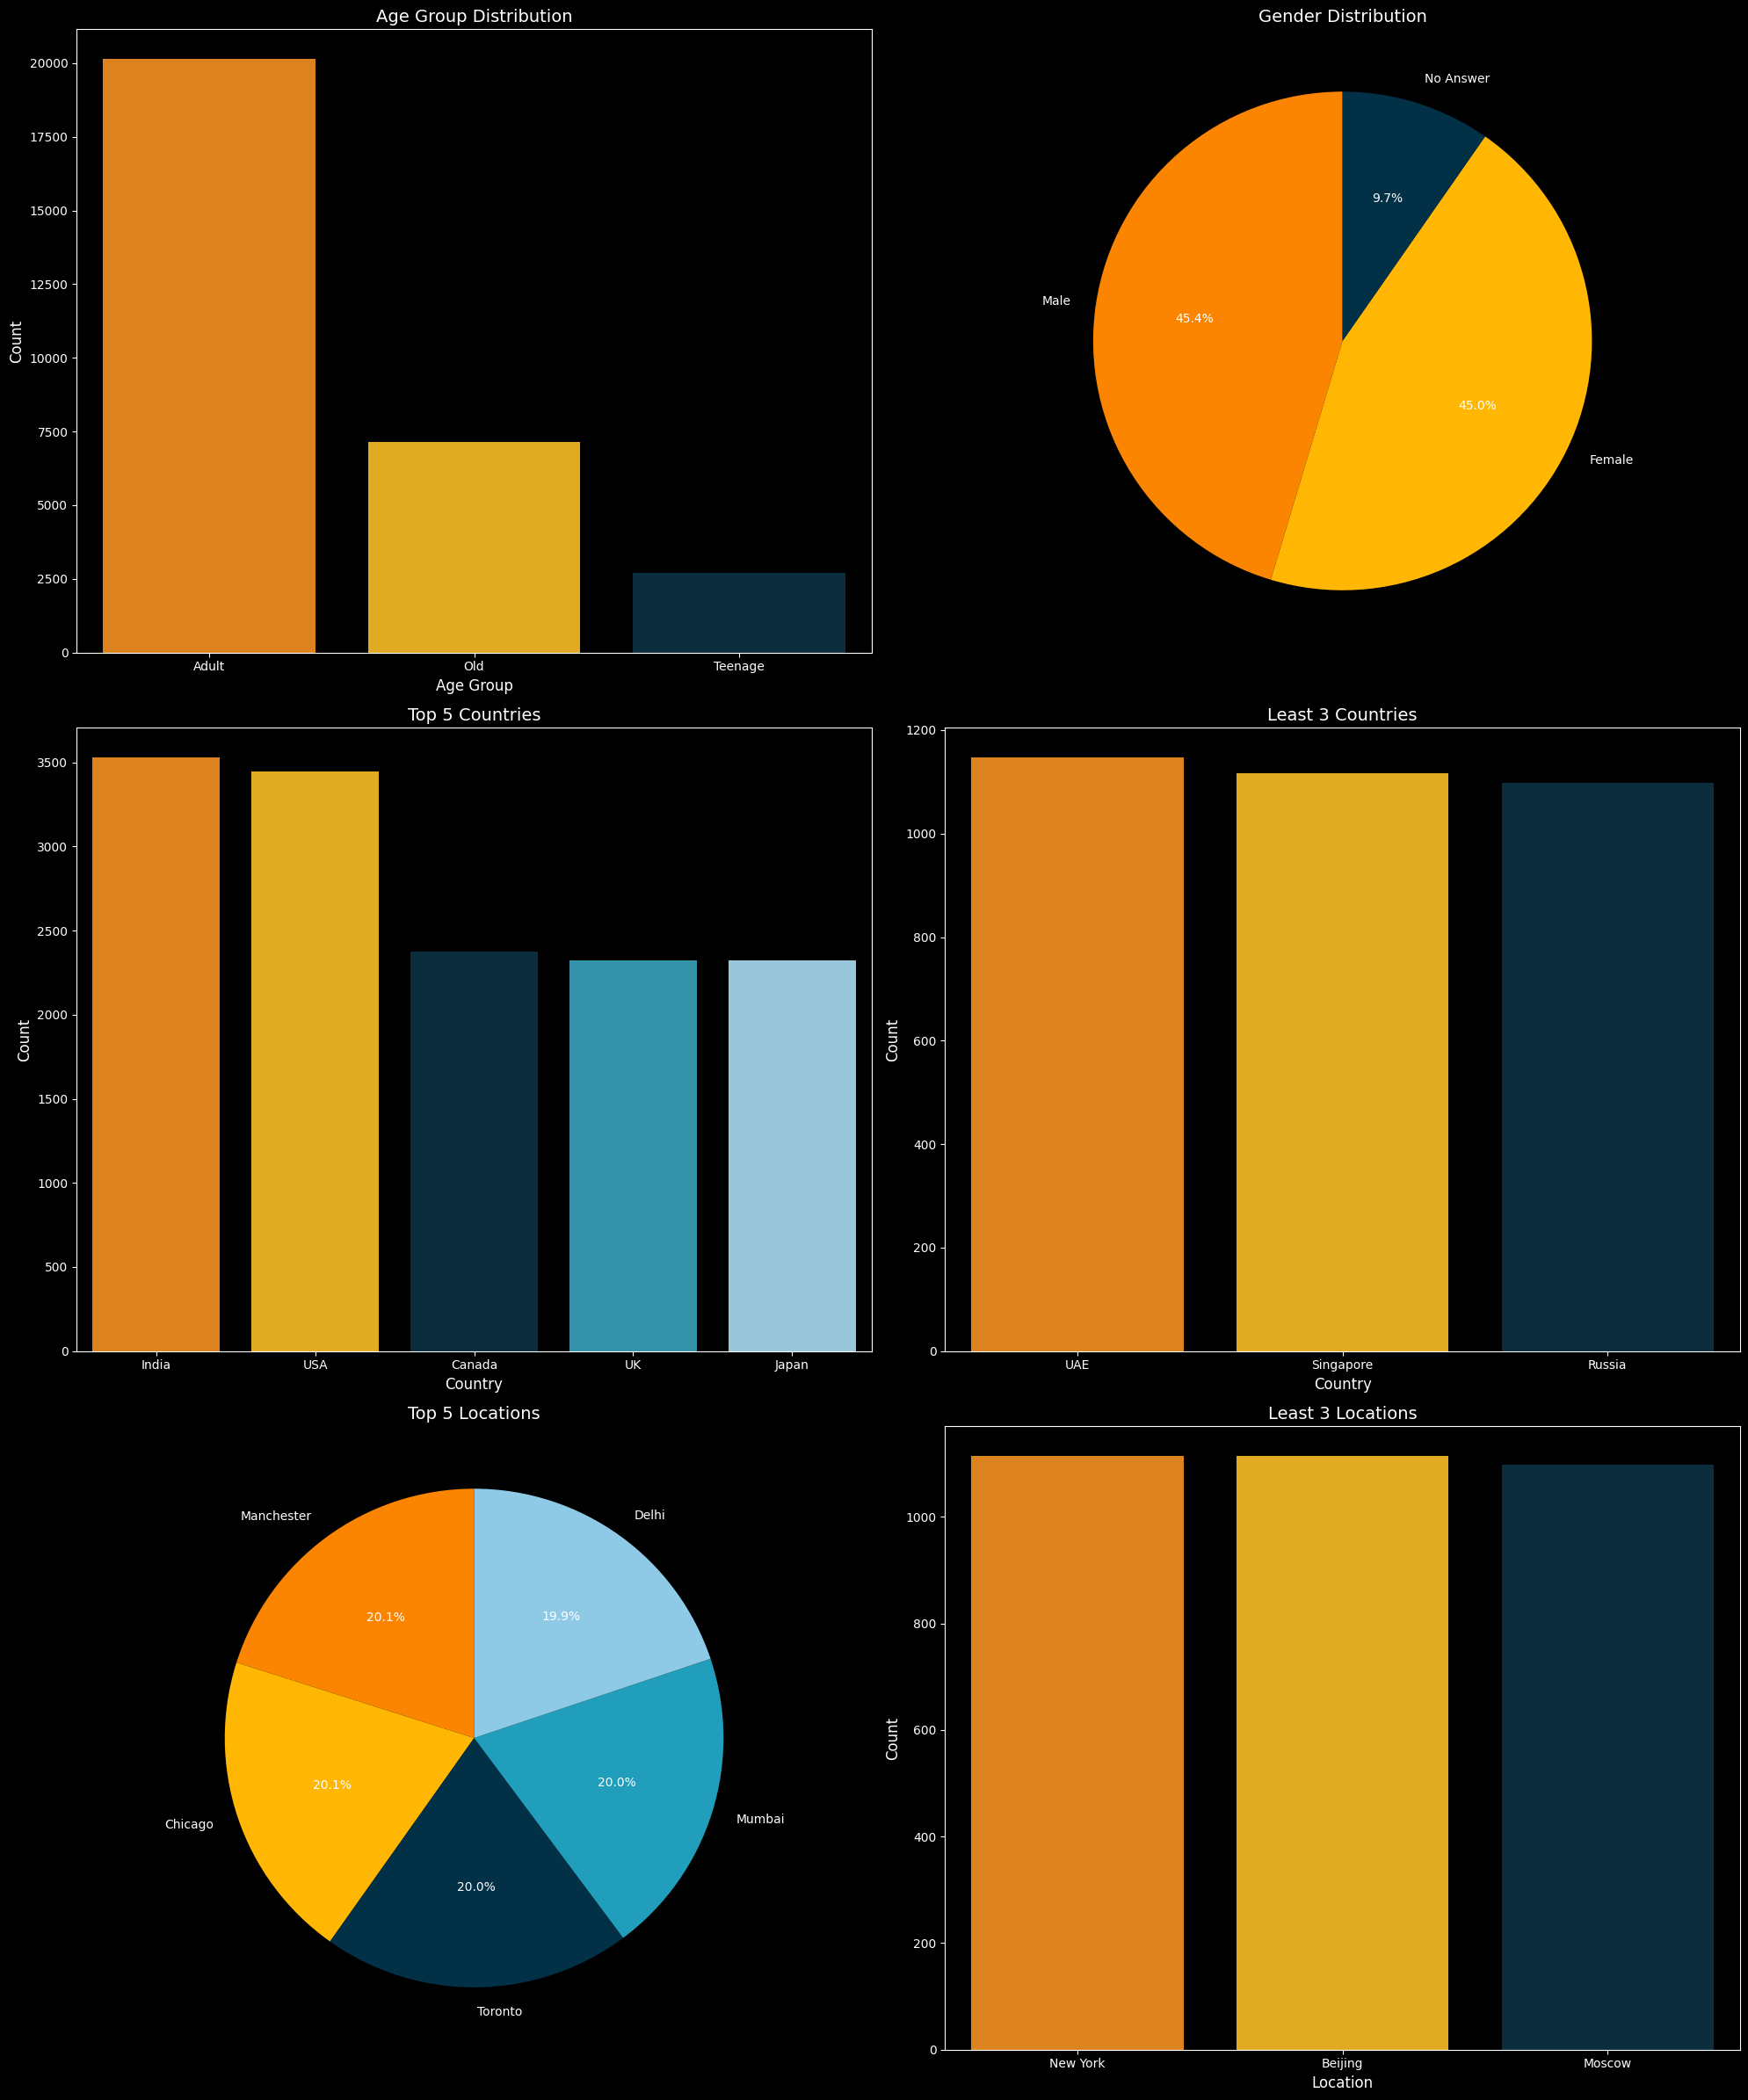

In [10]:
# Compute counts
age_group_counts = df['demographic_age_group'].value_counts()
gender_counts = df['demographic_gender'].value_counts()
country_counts = df['country'].value_counts()
location_counts = df['location'].value_counts()

# Top 5 and Least 3 Countries
top_5_countries = country_counts.head(5)
least_3_countries = country_counts.tail(3)

# Top 5 and Least 3 Locations
top_5_locations = location_counts.head(5)
least_3_locations = location_counts.tail(3)

# Custom color palette
color_palette = ['#FB8500', '#FFB703', '#023047', '#219EBC', '#8ECAE6']

# Set the style to have a black background
plt.style.use('dark_background')

# Create a subplot grid
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 24))
fig.patch.set_facecolor('black')  # Set the background color of the figure

# 1. Age Group Distribution (Bar Chart)
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette=color_palette, ax=axes[0, 0])
axes[0, 0].set_title("Age Group Distribution", fontsize=14, color='white')
axes[0, 0].set_xlabel("Age Group", fontsize=12, color='white')
axes[0, 0].set_ylabel("Count", fontsize=12, color='white')

# 2. Gender Distribution (Pie Chart)
axes[0, 1].pie(gender_counts.values, labels=gender_counts.index, colors=color_palette, autopct='%1.1f%%', startangle=90)
axes[0, 1].set_title("Gender Distribution", fontsize=14, color='white')

# 3. Top 5 Countries (Bar Chart)
sns.barplot(x=top_5_countries.index, y=top_5_countries.values, palette=color_palette, ax=axes[1, 0])
axes[1, 0].set_title("Top 5 Countries", fontsize=14, color='white')
axes[1, 0].set_xlabel("Country", fontsize=12, color='white')
axes[1, 0].set_ylabel("Count", fontsize=12, color='white')

# 4. Least 3 Countries (Bar Chart)
sns.barplot(x=least_3_countries.index, y=least_3_countries.values, palette=color_palette[:3], ax=axes[1, 1])
axes[1, 1].set_title("Least 3 Countries", fontsize=14, color='white')
axes[1, 1].set_xlabel("Country", fontsize=12, color='white')
axes[1, 1].set_ylabel("Count", fontsize=12, color='white')

# 5. Top 5 Locations (Pie Chart)
axes[2, 0].pie(top_5_locations.values, labels=top_5_locations.index, colors=color_palette, autopct='%1.1f%%', startangle=90)
axes[2, 0].set_title("Top 5 Locations", fontsize=14, color='white')

# 6. Least 3 Locations (Bar Chart)
sns.barplot(x=least_3_locations.index, y=least_3_locations.values, palette=color_palette[:3], ax=axes[2, 1])
axes[2, 1].set_title("Least 3 Locations", fontsize=14, color='white')
axes[2, 1].set_xlabel("Location", fontsize=12, color='white')
axes[2, 1].set_ylabel("Count", fontsize=12, color='white')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<center><h3 style="
    color: #8ECAE6;font-size: 20px;">1. What is the total number of unique visitors and their session frequency distribution </h3></center>

{'Unique Visitors': 12984}
{'Session Frequency Distribution': {'25%': 1.0,
                                    '50%': 2.0,
                                    '75%': 3.0,
                                    'count': 12984.0,
                                    'max': 9.0,
                                    'mean': 2.310536044362292,
                                    'min': 1.0,
                                    'std': 1.2548578843959328}}


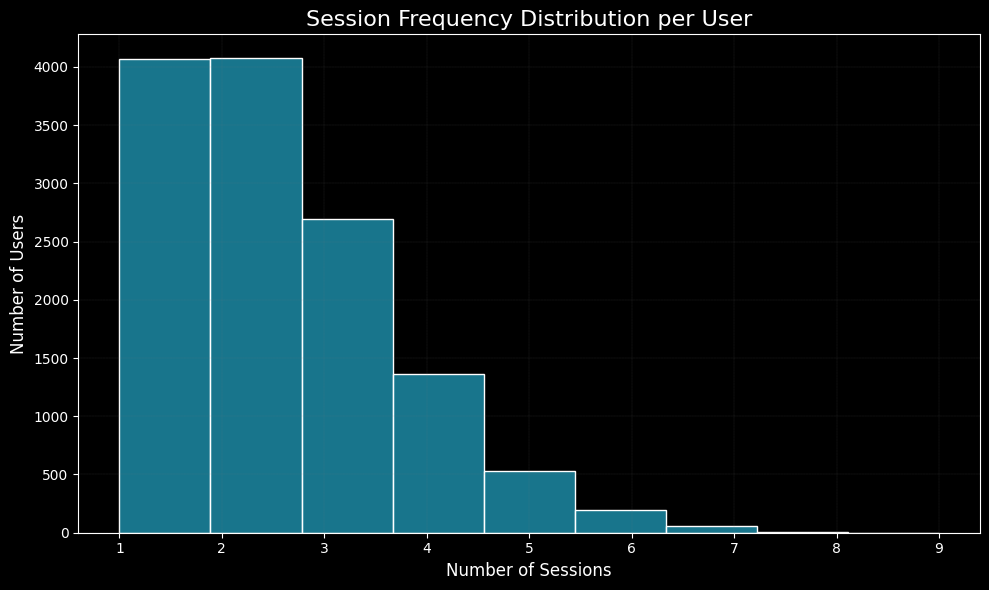

In [11]:
# Unique visitors count
unique_visitors = df['user_id'].nunique()
pprint({"Unique Visitors": unique_visitors})

# Session frequency distribution per user
session_freq = df.groupby('user_id').size()
pprint({"Session Frequency Distribution": session_freq.describe().to_dict()})

# Set the style to have a black background
plt.style.use('dark_background')

# Plotting the session frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(
    session_freq, 
    bins=int(session_freq.max()),  # Number of bins as an integer
    color='#219EBC',  # Custom color
    kde=False  # Disable KDE for a clean histogram
)

# Customize the plot
plt.title("Session Frequency Distribution per User", fontsize=16, color='white')
plt.xlabel("Number of Sessions", fontsize=12, color='white')
plt.ylabel("Number of Users", fontsize=12, color='white')

# Set black background
plt.gca().set_facecolor('black')  # Background of the plot
plt.gcf().set_facecolor('black')  # Background of the figure

# Customize gridlines
plt.grid(True, color='gray', linestyle='--', linewidth=0.1)

# Show the plot
plt.tight_layout()
plt.show()

<center><h3 style="
    color: #8ECAE6;font-size: 20px;">2. How do Email and Guest sign-in methods impact overall conversion rates and revenue?</h3></center>

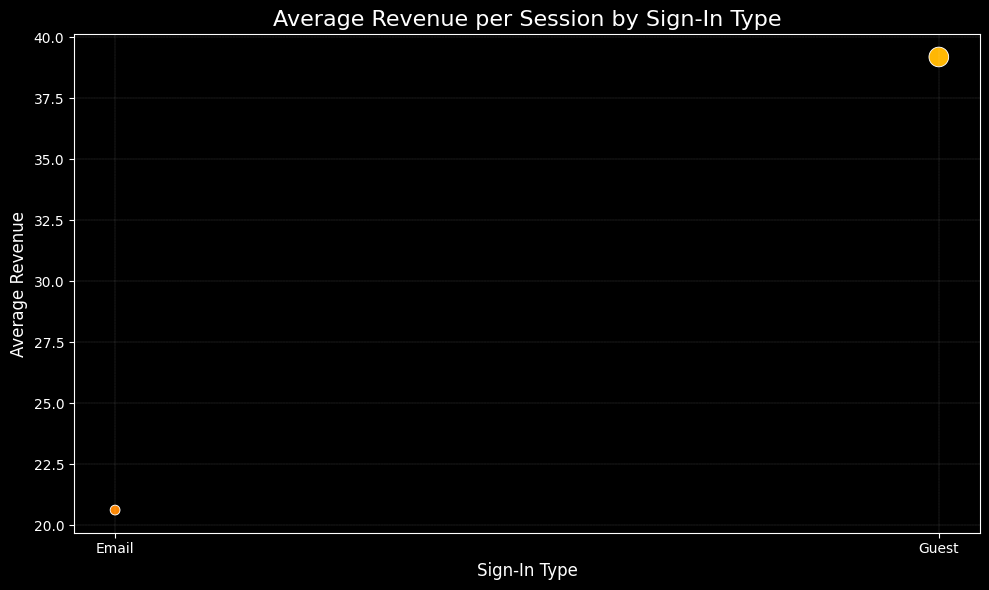

In [12]:
# Group by sign-in type and calculate metrics
sign_in_analysis = df.groupby('sign_in').agg(
    total_sessions=('session_id', 'count'),
    conversions=('conversion_flag', 'count'),
    total_revenue=('revenue_$', 'sum')
)

# Calculate conversion rate and average revenue
sign_in_analysis['conversion_rate'] = sign_in_analysis['conversions'] / sign_in_analysis['total_sessions']
sign_in_analysis['avg_revenue'] = sign_in_analysis['total_revenue'] / sign_in_analysis['total_sessions']

# Set the style to have a black background
plt.style.use('dark_background')

# Plot Average Revenue per Session by Sign-In Type (Scatter Plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sign_in_analysis.reset_index(), 
    x='sign_in', 
    y='avg_revenue', 
    hue='sign_in', 
    palette=['#FB8500', '#FFB703', '#023047'],  # Custom colors
    size='avg_revenue', 
    sizes=(50, 200),  # Size range for markers
    legend=False  # Hide legend
)

# Customize the plot
plt.title("Average Revenue per Session by Sign-In Type", fontsize=16, color='white')
plt.xlabel("Sign-In Type", fontsize=12, color='white')
plt.ylabel("Average Revenue", fontsize=12, color='white')

# Set black background
plt.gca().set_facecolor('black')  # Background of the plot
plt.gcf().set_facecolor('black')  # Background of the figure

# Customize gridlines
plt.grid(True, color='white', linestyle='--', linewidth=0.1)

# Show the plot
plt.tight_layout()
plt.show()

<center><h3 style="
    color: #8ECAE6;font-size: 20px;">3. How does the demographic age distribution (Teenage, Adult, Old) correlate with conversion performance?</h3></center>

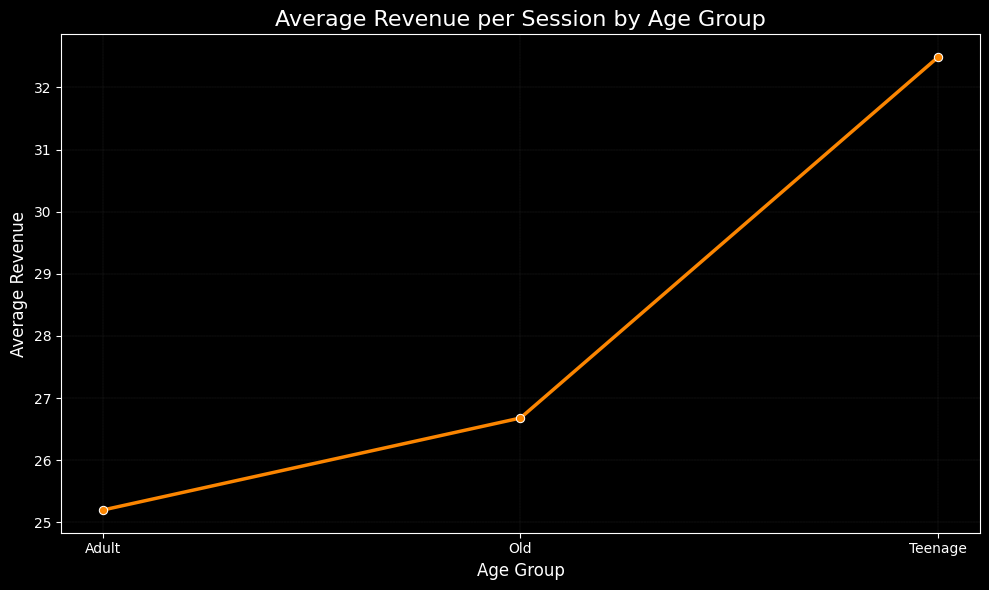

In [13]:
# Group by demographic age group and calculate metrics
age_group_summary = df.groupby("demographic_age_group").agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum()),
    total_revenue=("revenue_$", "sum")
).reset_index()

# Calculate conversion rate and average revenue
age_group_summary["conversion_rate"] = age_group_summary["conversions"] / age_group_summary["total_sessions"]
age_group_summary["avg_revenue"] = age_group_summary["total_revenue"] / age_group_summary["total_sessions"]

# Set the style to have a black background
plt.style.use('dark_background')

# Plot Average Revenue per Session by Demographic Age Group (Line Chart with Markers)
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=age_group_summary, 
    x="demographic_age_group", 
    y="avg_revenue", 
    marker='o',  # Add markers to the line
    color='#FB8500',  # Custom color
    linewidth=2.5  # Line thickness
)

# Customize the plot
plt.title("Average Revenue per Session by Age Group", fontsize=16, color='white')
plt.xlabel("Age Group", fontsize=12, color='white')
plt.ylabel("Average Revenue", fontsize=12, color='white')

# Set black background
plt.gca().set_facecolor('black')  # Background of the plot
plt.gcf().set_facecolor('black')  # Background of the figure

# Customize gridlines
plt.grid(True, color='gray', linestyle='--', linewidth=0.1)

# Show the plot
plt.tight_layout()
plt.show()

<center><h3 style="
    color: #8ECAE6;font-size: 20px;">4. What is the gender distribution among users, and how does it affect engagement and conversions?</h3></center>

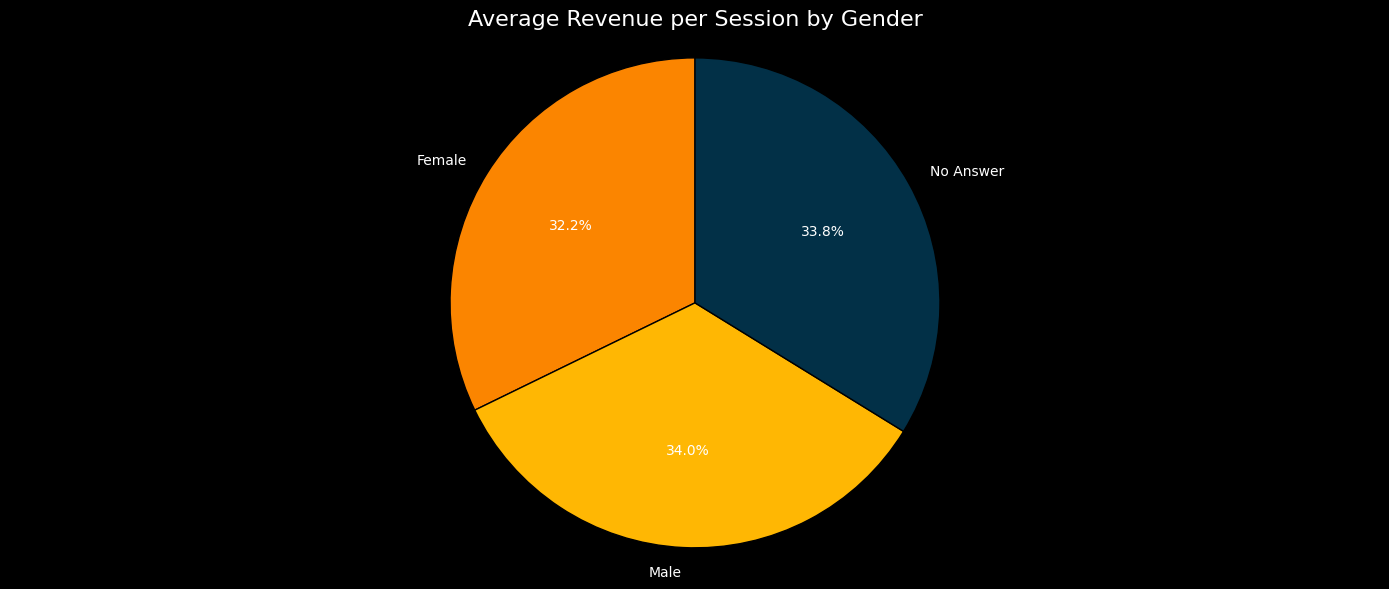

In [14]:
# Group by gender and calculate metrics
gender_summary = df.groupby("demographic_gender").agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum()),
    avg_time_spent=("time_spent", "mean"),
    avg_pages_visited=("pages_visited", "mean"),
    total_revenue=("revenue_$", "sum")
).reset_index()

# Calculate conversion rate and average revenue
gender_summary["conversion_rate"] = gender_summary["conversions"] / gender_summary["total_sessions"]
gender_summary["avg_revenue"] = gender_summary["total_revenue"] / gender_summary["total_sessions"]

# Set the style to have a black background
plt.style.use('dark_background')

# Create a figure and axis with a black background
fig, ax = plt.subplots(figsize=(14, 6))  # Increase width to 14 (or as needed) for full-page display
fig.patch.set_facecolor('black')  # Set the background color of the figure
ax.set_facecolor('black')  # Set the background color of the axis

# Plot Average Revenue per Session by Gender (Pie Chart)
wedges, texts, autotexts = ax.pie(
    gender_summary["avg_revenue"], 
    labels=gender_summary["demographic_gender"], 
    autopct='%1.1f%%',  # Show percentages
    startangle=90,  # Rotate the pie chart
    colors=['#FB8500', '#FFB703', '#023047'],  # Custom colors
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}  # Add edges to the pie slices
)

# Customize the plot
plt.title("Average Revenue per Session by Gender", fontsize=16, color='white')

# Center the pie chart
ax.axis('equal')  # Ensures the pie chart is circular and centered

# Customize text colors
for text in texts:
    text.set_color('white')  # Set label text color to white
for autotext in autotexts:
    autotext.set_color('white')  # Set percentage text color to white

# Show the plot
plt.tight_layout()
plt.show()

<center><h3 style="
    color: #8ECAE6;font-size: 20px;">5. Which countries generate the highest traffic and conversion rates?</h3></center>

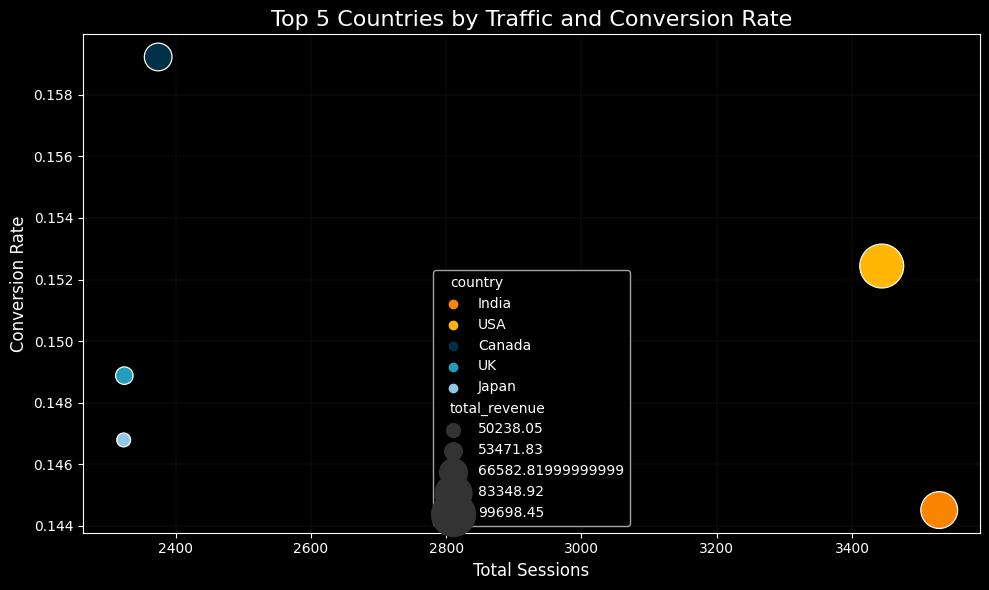

In [15]:
# Group by country and calculate metrics
country_summary = df.groupby("country").agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum()),
    total_revenue=("revenue_$", "sum")
).reset_index()

# Calculate conversion rate
country_summary["conversion_rate"] = country_summary["conversions"] / country_summary["total_sessions"]

# Get top 5 countries by total sessions
top_5_countries = country_summary.sort_values("total_sessions", ascending=False).head(5)

# Set the style to have a black background
plt.style.use('dark_background')

# Plot Top 5 Countries by Traffic and Conversion Rate (Bubble Chart)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=top_5_countries, 
    x="total_sessions", 
    y="conversion_rate", 
    size="total_revenue",  # Bubble size based on total revenue
    hue="country",  # Color by country
    palette=['#FB8500', '#FFB703', '#023047', '#219EBC', '#8ECAE6'],  # Custom colors
    sizes=(100, 1000),  # Size range for bubbles
    legend="full"  # Show legend
)

# Customize the plot
plt.title("Top 5 Countries by Traffic and Conversion Rate", fontsize=16, color='white')
plt.xlabel("Total Sessions", fontsize=12, color='white')
plt.ylabel("Conversion Rate", fontsize=12, color='white')

# Set black background
plt.gca().set_facecolor('black')  # Background of the plot
plt.gcf().set_facecolor('black')  # Background of the figure

# Customize gridlines
plt.grid(True, color='gray', linestyle='--', linewidth=0.1)

# Show the plot
plt.tight_layout()
plt.show()

<center><h3 style="
    color: #8ECAE6;font-size: 20px;">6. Which cities are the top drivers of user engagement and revenue?</h3></center>

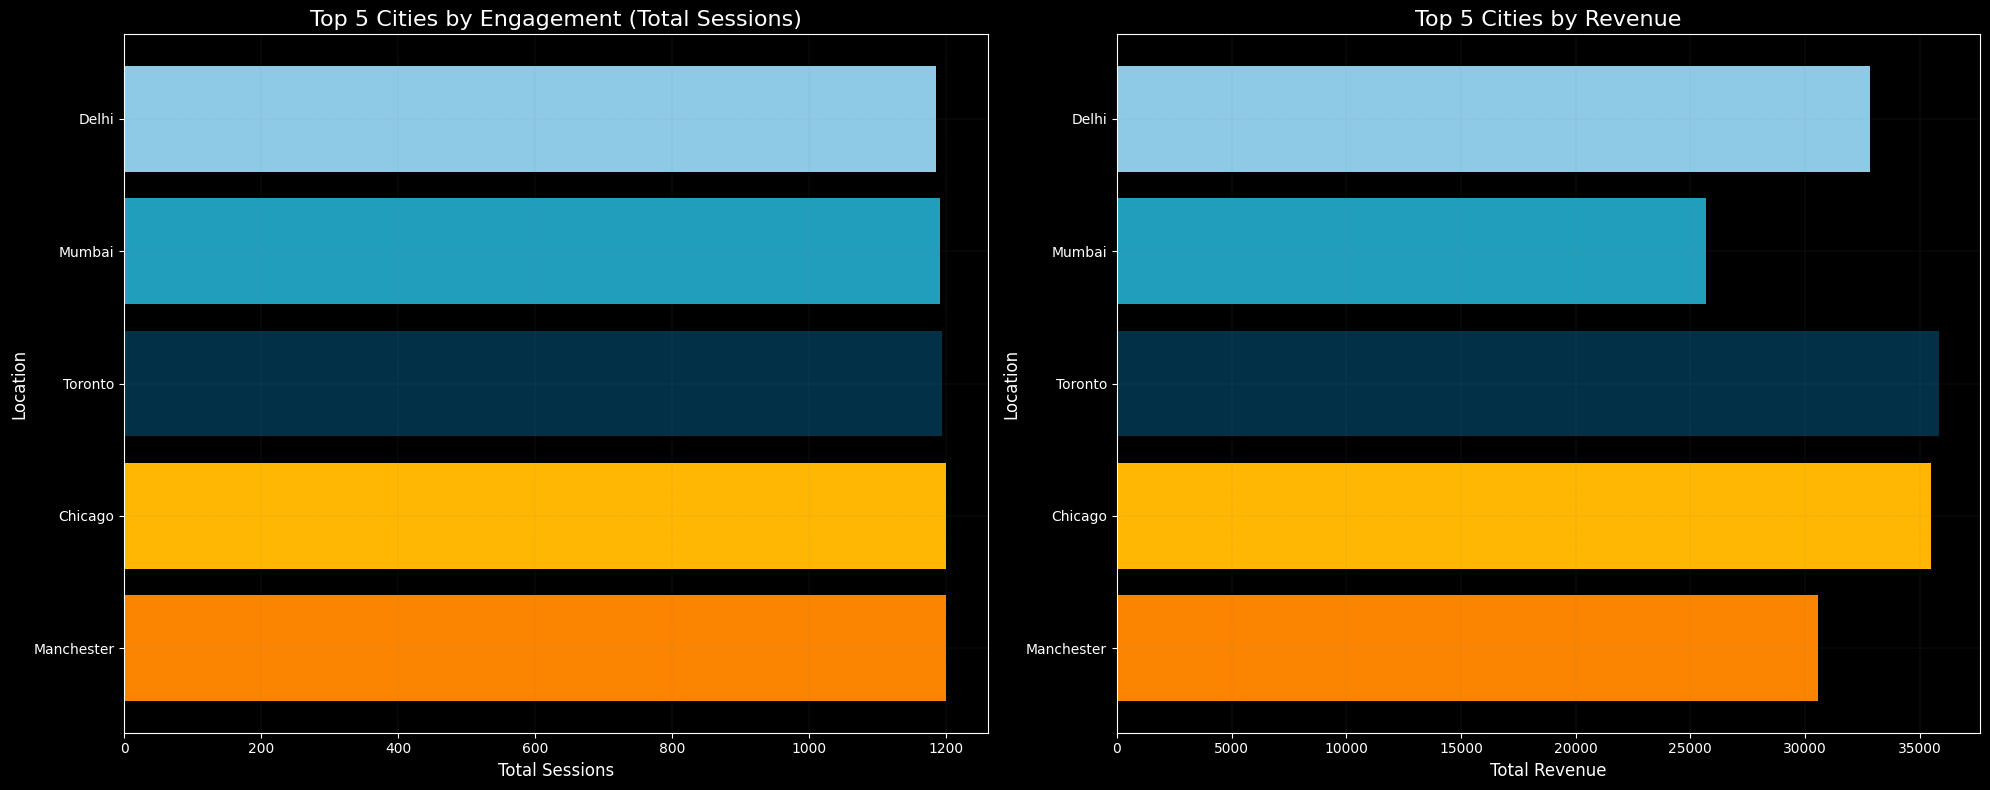

In [16]:
# Group by location and calculate metrics
city_summary = df.groupby("location").agg(
    total_sessions=("session_id", "count"),
    total_revenue=("revenue_$", "sum")
).reset_index()

# Get top 5 cities by total sessions
top_5_cities = city_summary.sort_values("total_sessions", ascending=False).head(5)

# Set the style to have a black background
plt.style.use('dark_background')

# Create a subplot grid
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
fig.patch.set_facecolor('black')  # Set the background color of the figure

# Plot 1: Treemap for Total Sessions (Engagement)
axes[0].barh(top_5_cities["location"], top_5_cities["total_sessions"], color=['#FB8500', '#FFB703', '#023047', '#219EBC', '#8ECAE6'])
axes[0].set_title("Top 5 Cities by Engagement (Total Sessions)", fontsize=16, color='white')
axes[0].set_xlabel("Total Sessions", fontsize=12, color='white')
axes[0].set_ylabel("Location", fontsize=12, color='white')

# Plot 2: Treemap for Total Revenue
axes[1].barh(top_5_cities["location"], top_5_cities["total_revenue"], color=['#FB8500', '#FFB703', '#023047', '#219EBC', '#8ECAE6'])
axes[1].set_title("Top 5 Cities by Revenue", fontsize=16, color='white')
axes[1].set_xlabel("Total Revenue", fontsize=12, color='white')
axes[1].set_ylabel("Location", fontsize=12, color='white')

# Customize gridlines
for ax in axes:
    ax.grid(True, color='gray', linestyle='--', linewidth=0.1)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

<center><h3 style="
    color: #8ECAE6;font-size: 20px;">7. How does device type (Mobile, Desktop, Tablet) influence session duration and conversion outcomes?</h3></center>

In [17]:
# Group data by device type to analyze session duration and conversion outcomes
device_summary = df.groupby("device_type").agg(
    total_sessions=("session_id", "count"),
    avg_time_spent=("time_spent", "mean"),
    conversions=("conversion_flag", lambda x: (x == 1).sum()),
    avg_pages_visited=("pages_visited", "mean")
).reset_index()

device_summary["conversion_rate"] = device_summary["conversions"] / device_summary["total_sessions"]

pprint(device_summary.to_dict(orient="records"))

[{'avg_pages_visited': 5.499385680777393,
  'avg_time_spent': 10.451435273092818,
  'conversion_rate': 0.152686250418854,
  'conversions': 1367,
  'device_type': 'Desktop',
  'total_sessions': 8953},
 {'avg_pages_visited': 5.505997334517992,
  'avg_time_spent': 10.525802421146157,
  'conversion_rate': 0.14948911594846734,
  'conversions': 2692,
  'device_type': 'Mobile',
  'total_sessions': 18008},
 {'avg_pages_visited': 5.4807502467917075,
  'avg_time_spent': 10.728923988153998,
  'conversion_rate': 0.15663047054952287,
  'conversions': 476,
  'device_type': 'Tablet',
  'total_sessions': 3039}]


<center><h3 style="
    color: #8ECAE6;font-size: 20px;">8. Which landing page variant (Vibrant, Cold, Heat) achieves the highest conversion rates?</h3></center>

In [18]:
# Group data by landing page variant and calculate conversion metrics
variant_summary = df.groupby("variant_group").agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum())
).reset_index()

variant_summary["conversion_rate"] = variant_summary["conversions"] / variant_summary["total_sessions"]

pprint(variant_summary.to_dict(orient="records"))

# Identify the variant with the highest conversion rate
highest_variant = variant_summary.loc[variant_summary["conversion_rate"].idxmax(), "variant_group"]
print("Landing Page Variant with Highest Conversion Rate:", highest_variant)

[{'conversion_rate': 0.18080177276390008,
  'conversions': 1795,
  'total_sessions': 9928,
  'variant_group': 'Cold'},
 {'conversion_rate': 0.15170556552962297,
  'conversions': 1521,
  'total_sessions': 10026,
  'variant_group': 'Heat'},
 {'conversion_rate': 0.12134182759307187,
  'conversions': 1219,
  'total_sessions': 10046,
  'variant_group': 'Vibrant'}]
Landing Page Variant with Highest Conversion Rate: Cold


<center><h3 style="
    color: #8ECAE6;font-size: 20px;">9. What is the average time spent on the website per session, and how does it vary by variant?</h3></center>

In [19]:
# Calculate the overall average time spent per session
overall_avg_time = df["time_spent"].mean()
pprint({"Overall Average Time Spent (minutes)": overall_avg_time})

# Group by landing page variant and calculate the average time spent per session
variant_time_summary = df.groupby("variant_group").agg(
    avg_time_spent=("time_spent", "mean")
).reset_index()

pprint(variant_time_summary.to_dict(orient="records"))

{'Overall Average Time Spent (minutes)': 10.524185}
[{'avg_time_spent': 10.534522562449638, 'variant_group': 'Cold'},
 {'avg_time_spent': 10.481271693596648, 'variant_group': 'Heat'},
 {'avg_time_spent': 10.556796735018914, 'variant_group': 'Vibrant'}]


<center><h3 style="
    color: #8ECAE6;font-size: 20px;">10. How many pages are typically visited per session, and what is the correlation with conversion success?</h3></center>

In [20]:
# Descriptive statistics for pages_visited
pages_stats = df['pages_visited'].describe()
pprint({"Pages Visited Stats": pages_stats.to_dict()})
# Calculate correlation between pages_visited and conversion_flag
correlation = df['pages_visited'].corr(df['conversion_flag'])
pprint({"Correlation between Pages Visited and Conversion Flag": correlation})
# Group by pages_visited and calculate conversion rate
pages_conversion = df.groupby("pages_visited").agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum())
).reset_index()
pages_conversion["conversion_rate"] = pages_conversion["conversions"] / pages_conversion["total_sessions"]
pprint({"Pages Conversion Analysis": pages_conversion.to_dict(orient="records")})


{'Pages Visited Stats': {'25%': 3.0,
                         '50%': 5.0,
                         '75%': 8.0,
                         'count': 30000.0,
                         'max': 10.0,
                         'mean': 5.5014666666666665,
                         'min': 1.0,
                         'std': 2.8742082767252426}}
{'Correlation between Pages Visited and Conversion Flag': -0.003501550504047043}
{'Pages Conversion Analysis': [{'conversion_rate': 0.15880398671096346,
                                'conversions': 478,
                                'pages_visited': 1,
                                'total_sessions': 3010},
                               {'conversion_rate': 0.15463917525773196,
                                'conversions': 465,
                                'pages_visited': 2,
                                'total_sessions': 3007},
                               {'conversion_rate': 0.15075885328836425,
                                'conversions':

<center><h3 style="
    color: #8ECAE6;font-size: 20px;">11. What are the overall conversion rates, and how do they differ by landing page variant?</h3></center>

In [21]:
# Overall conversion rate
overall_conversion_rate = df['conversion_flag'].sum() / df.shape[0]
pprint({"Overall Conversion Rate": overall_conversion_rate})
# Conversion rate by landing page variant
variant_summary = df.groupby("variant_group").agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum())
).reset_index()

variant_summary["conversion_rate"] = variant_summary["conversions"] / variant_summary["total_sessions"]
pprint(variant_summary.to_dict(orient="records"))

{'Overall Conversion Rate': 0.15116666666666667}
[{'conversion_rate': 0.18080177276390008,
  'conversions': 1795,
  'total_sessions': 9928,
  'variant_group': 'Cold'},
 {'conversion_rate': 0.15170556552962297,
  'conversions': 1521,
  'total_sessions': 10026,
  'variant_group': 'Heat'},
 {'conversion_rate': 0.12134182759307187,
  'conversions': 1219,
  'total_sessions': 10046,
  'variant_group': 'Vibrant'}]


<center><h3 style="
    color: #8ECAE6;font-size: 20px;">12. How do various traffic sources (Organic, Paid, Social, Referral) compare in terms of session quality and conversion performance?</h3></center>

In [22]:
# Aggregate metrics by traffic source
traffic_summary = df.groupby("traffic_source").agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum()),
    total_revenue=("revenue_$", "sum"),
    avg_time_spent=("time_spent", "mean"),
    avg_pages_visited=("pages_visited", "mean")
).reset_index()

traffic_summary["conversion_rate"] = traffic_summary["conversions"] / traffic_summary["total_sessions"]

pprint(traffic_summary.to_dict(orient="records"))

[{'avg_pages_visited': 5.511402810925484,
  'avg_time_spent': 10.518695306284805,
  'conversion_rate': 0.1514850172368072,
  'conversions': 2285,
  'total_revenue': 412921.58,
  'total_sessions': 15084,
  'traffic_source': 'Organic'},
 {'avg_pages_visited': 5.524537815126051,
  'avg_time_spent': 10.4792756302521,
  'conversion_rate': 0.15680672268907564,
  'conversions': 933,
  'total_revenue': 150138.45,
  'total_sessions': 5950,
  'traffic_source': 'Paid'},
 {'avg_pages_visited': 5.519838601210491,
  'avg_time_spent': 10.431244115669132,
  'conversion_rate': 0.1516476126429052,
  'conversions': 451,
  'total_revenue': 80616.71,
  'total_sessions': 2974,
  'traffic_source': 'Referral'},
 {'avg_pages_visited': 5.444425901201602,
  'avg_time_spent': 10.628728304405874,
  'conversion_rate': 0.1445260347129506,
  'conversions': 866,
  'total_revenue': 142579.85,
  'total_sessions': 5992,
  'traffic_source': 'Social'}]


## Landing Page Insights and Suggestions

| **🧶Landing Page Variants**                                                                 |
|------------------------------------------------------------------------------------------|
| - **"Cold" variant** has the highest conversion rate at **18.1%**, while **"Vibrant"** lags at **12.1%**. |
| - **💪 Suggestion:** Prioritize and expand on the **"Cold"** design and consider revising the **"Vibrant"** variant. |

| **🧶Device Insights**                                                                      |
|------------------------------------------------------------------------------------------|
| - **Mobile** generates the highest session volume, though conversion rates are similar across devices with **Tablets** showing a slight edge. |
| - **💪 Suggestion:** Optimize mobile experience further while ensuring responsive design across all devices. |

| **🧶Traffic Sources**                                                                      |
|------------------------------------------------------------------------------------------|
| - **Organic traffic** drives the most sessions, but **Paid channels** exhibit a slightly higher conversion rate (**15.68%**). |
| - **💪 Suggestion:** Invest in targeted paid campaigns to complement organic efforts. |

| **🧶Overall Engagement**                                                                   |
|------------------------------------------------------------------------------------------|
| - Average session duration is around **10.5 minutes** with users visiting roughly **5.5 pages** per session, leading to an overall conversion rate of about **15.1%**. |
| - **💪 Suggestion:** Enhance on-site engagement to push the conversion rate higher by optimizing user journey and content. |


<center><h3 style="
    color: #8ECAE6;font-size: 20px;">13. Which products are purchased most frequently, and which contribute the most to total revenue?</h3></center>

In [23]:
# Filter only purchase conversions
purchase_df = df[df['conversion_type'] == "Purchase"]

# Aggregate data by product: count purchases and sum revenue
product_summary = purchase_df.groupby('product_purchased').agg(
    total_purchases=('session_id', 'count'),
    total_revenue=('revenue_$', 'sum')
).reset_index()

# Top 5 products by purchase frequency
top5_by_purchases = product_summary.sort_values(by='total_purchases', ascending=False).head(5)
pprint({"Top 5 Products by Purchase Frequency": top5_by_purchases.to_dict(orient="records")})

# Top 5 products by revenue contribution
top5_by_revenue = product_summary.sort_values(by='total_revenue', ascending=False).head(5)
pprint({"Top 5 Products by Revenue": top5_by_revenue.to_dict(orient="records")})

{'Top 5 Products by Purchase Frequency': [{'product_purchased': 'JBL Flip 6',
                                           'total_purchases': 63,
                                           'total_revenue': 8186.849999999999},
                                          {'product_purchased': 'Anker '
                                                                'Soundcore 3',
                                           'total_purchases': 55,
                                           'total_revenue': 2749.4500000000003},
                                          {'product_purchased': 'LG XBOOM Go '
                                                                'PL7',
                                           'total_purchases': 53,
                                           'total_revenue': 10599.470000000001},
                                          {'product_purchased': 'Sony SRS-XB33',
                                           'total_purchases': 53,
                                 


<center><h3 style="
    color: #8ECAE6;font-size: 20px;">14. How does coupon usage affect conversion rates and average order values?</h3></center>

In [24]:
# Filter purchase conversions
purchase_df = df[(df['conversion_flag'] == 1) & (df['conversion_type'] == "Purchase")]

# Calculate coupon usage rate among purchase conversions
coupon_usage_rate = purchase_df['coupon_applied'].value_counts(normalize=True)
pprint({"Coupon Usage Rate": coupon_usage_rate.to_dict()})

# Aggregate data by coupon usage to get total purchases and total revenue
coupon_summary = purchase_df.groupby("coupon_applied").agg(
    total_purchases=('session_id', 'count'),
    total_revenue=('revenue_$', 'sum')
).reset_index()

# Calculate average order value for each coupon usage group
coupon_summary["avg_order_value"] = coupon_summary["total_revenue"] / coupon_summary["total_purchases"]

pprint(coupon_summary.to_dict(orient="records"))

{'Coupon Usage Rate': {'No': 0.7105614973262032, 'Yes': 0.2894385026737968}}
[{'avg_order_value': 261.60024929444967,
  'coupon_applied': 'No',
  'total_purchases': 2126,
  'total_revenue': 556162.13},
 {'avg_order_value': 265.6979907621247,
  'coupon_applied': 'Yes',
  'total_purchases': 866,
  'total_revenue': 230094.46}]



<center><h3 style="
    color: #8ECAE6;font-size: 20px;">15. What is the breakdown of payment methods (Card vs. COD) and their impact on revenue?</h3></center>

In [25]:
# Filter for purchase conversions only
purchase_df = df[(df['conversion_flag'] == 1) & (df['conversion_type'] == "Purchase")]

# Group by payment type to calculate total purchases, total revenue, and average order value
payment_summary = purchase_df.groupby('payment_type').agg(
    total_purchases=('session_id', 'count'),
    total_revenue=('revenue_$', 'sum')
).reset_index()

payment_summary['avg_order_value'] = payment_summary['total_revenue'] / payment_summary['total_purchases']

pprint(payment_summary.to_dict(orient='records'))

[{'avg_order_value': 245.18122630992195,
  'payment_type': 'COD',
  'total_purchases': 897,
  'total_revenue': 219927.56},
 {'avg_order_value': 270.3241193317423,
  'payment_type': 'Card',
  'total_purchases': 2095,
  'total_revenue': 566329.03}]



<center><h3 style="
    color: #8ECAE6;font-size: 20px;">16. Among card payments, what are the distributions and performance differences between Amex, Visa, and Master?</h3></center>


In [26]:
# Filter for card payments in purchase conversions
card_df = df[(df['conversion_flag'] == 1) & (df['conversion_type'] == "Purchase") & (df['payment_type'] == "Card")]

# Group by card type and calculate total purchases and total revenue
card_summary = card_df.groupby("card_type").agg(
    total_purchases=("session_id", "count"),
    total_revenue=("revenue_$", "sum")
).reset_index()

# Calculate average order value for each card type
card_summary["avg_order_value"] = card_summary["total_revenue"] / card_summary["total_purchases"]

pprint(card_summary.to_dict(orient="records"))

[{'avg_order_value': 283.0930383480826,
  'card_type': 'Amex',
  'total_purchases': 678,
  'total_revenue': 191937.08},
 {'avg_order_value': 259.0654738330976,
  'card_type': 'Master',
  'total_purchases': 707,
  'total_revenue': 183159.29},
 {'avg_order_value': 269.34177464788735,
  'card_type': 'Visa',
  'total_purchases': 710,
  'total_revenue': 191232.66}]



<center><h3 style="
    color: #8ECAE6;font-size: 20px;">17. How do repeat visit patterns (frequency and recency) relate to higher conversion and revenue per user?</h3></center>

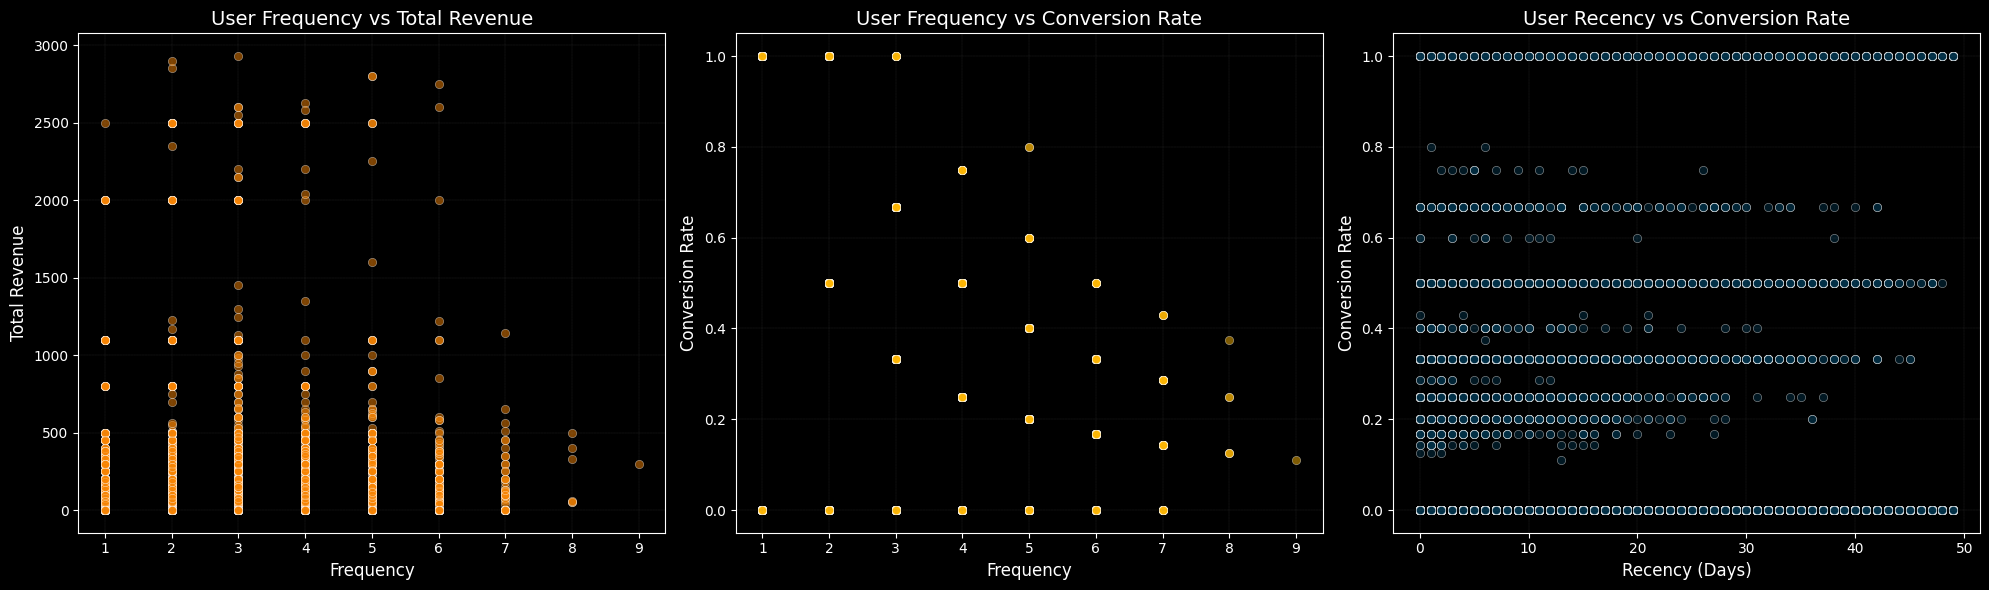

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Compute the maximum timestamp (assumed as the current reference)
max_timestamp = df['timestamp'].max()

# Group by user_id to compute repeat visit metrics
user_metrics = df.groupby('user_id').agg(
    frequency=('session_id', 'count'),
    first_visit=('timestamp', 'min'),
    last_visit=('timestamp', 'max'),
    total_conversions=('conversion_flag', lambda x: (x == 1).sum()),
    total_revenue=('revenue_$', 'sum')
).reset_index()

# Calculate conversion rate per user
user_metrics['conversion_rate'] = user_metrics['total_conversions'] / user_metrics['frequency']

# Calculate recency: days since the last visit relative to the maximum timestamp in the dataset
user_metrics['recency'] = (max_timestamp - user_metrics['last_visit']).dt.days

# Set the style to have a black background
plt.style.use('dark_background')

# Create a subplot grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
fig.patch.set_facecolor('black')  # Set the background color of the figure

# Scatter Plot: Frequency vs Total Revenue
sns.scatterplot(
    data=user_metrics, 
    x='frequency', 
    y='total_revenue', 
    color='#FB8500',  # Custom color
    alpha=0.5,  # Transparency
    ax=axes[0]
)
axes[0].set_title("User Frequency vs Total Revenue", fontsize=14, color='white')
axes[0].set_xlabel("Frequency", fontsize=12, color='white')
axes[0].set_ylabel("Total Revenue", fontsize=12, color='white')

# Scatter Plot: Frequency vs Conversion Rate
sns.scatterplot(
    data=user_metrics, 
    x='frequency', 
    y='conversion_rate', 
    color='#FFB703',  # Custom color
    alpha=0.5,  # Transparency
    ax=axes[1]
)
axes[1].set_title("User Frequency vs Conversion Rate", fontsize=14, color='white')
axes[1].set_xlabel("Frequency", fontsize=12, color='white')
axes[1].set_ylabel("Conversion Rate", fontsize=12, color='white')

# Scatter Plot: Recency vs Conversion Rate
sns.scatterplot(
    data=user_metrics, 
    x='recency', 
    y='conversion_rate', 
    color='#023047',  # Custom color
    alpha=0.5,  # Transparency
    ax=axes[2]
)
axes[2].set_title("User Recency vs Conversion Rate", fontsize=14, color='white')
axes[2].set_xlabel("Recency (Days)", fontsize=12, color='white')
axes[2].set_ylabel("Conversion Rate", fontsize=12, color='white')

# Customize gridlines
for ax in axes:
    ax.grid(True, color='gray', linestyle='--', linewidth=0.1)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


<center><h3 style="
    color: #8ECAE6;font-size: 20px;">18. What are the behavioral differences between first-time visitors and returning users in terms of engagement?</h3></center>

In [28]:
# Aggregate user-level engagement metrics
user_engagement = df.groupby('user_id').agg(
    session_count=('session_id', 'count'),
    avg_time_spent=('time_spent', 'mean'),
    avg_pages_visited=('pages_visited', 'mean')
).reset_index()

# Classify users as First-time (only 1 session) or Returning (more than 1 session)
user_engagement['visitor_type'] = user_engagement['session_count'].apply(lambda x: 'First-time' if x == 1 else 'Returning')

# Summarize engagement metrics by visitor type
behavioral_summary = user_engagement.groupby('visitor_type').agg(
    total_users=('user_id', 'count'),
    avg_sessions=('session_count', 'mean'),
    avg_time_spent=('avg_time_spent', 'mean'),
    avg_pages_visited=('avg_pages_visited', 'mean')
).reset_index()

pprint(behavioral_summary.to_dict(orient='records'))

[{'avg_pages_visited': 5.502829028290283,
  'avg_sessions': 1.0,
  'avg_time_spent': 10.453286592865929,
  'total_users': 4065,
  'visitor_type': 'First-time'},
 {'avg_pages_visited': 5.498092132543865,
  'avg_sessions': 2.9078372014799867,
  'avg_time_spent': 10.531922101381571,
  'total_users': 8919,
  'visitor_type': 'Returning'}]


## Product Performance Insights and Suggestions

| **🧶Product Performance**                                                                 |
|----------------------------------------------------------------------------------------|
| - **Best-sellers by frequency:** JBL Flip 6, Anker Soundcore 3, LG XBOOM Go PL7.       |
| - **Highest revenue generators:** Bang & Olufsen Beosound A9, Sennheiser AMBEO Smart Speaker. |
| - **💪 Suggestion:** Promote both affordable, high-frequency sellers and premium high-revenue products. |

| **🧶Coupon Usage**                                                                       |
|----------------------------------------------------------------------------------------|
| - **29% of purchases** use coupons with similar average order values.                  |
| - **💪 Suggestion:** Refine coupon strategies to boost conversions on selected products. |

| **🧶Payment Methods**                                                                    |
|----------------------------------------------------------------------------------------|
| - **Card payments dominate** and have higher average order values than COD.            |
| - **💪 Suggestion:** Enhance card payment options and offers to further drive revenue.  |

| **🧶Visitor Behavior**                                                                   |
|----------------------------------------------------------------------------------------|
| - **Returning users** show higher engagement (more sessions, pages, time) than first-timers. |
| - **💪 Suggestion:** Invest in retention strategies and loyalty programs to encourage repeat visits. |

| **🧶User-Level Metrics**                                                                 |
|----------------------------------------------------------------------------------------|
| - **Higher session frequency** correlates with increased revenue.                      |
| - **💪 Suggestion:** Encourage frequent visits through targeted re-engagement campaigns. |


<center><h3 style="
    color: #8ECAE6;font-size: 20px;">19. How does the conversion type (Signup vs. Purchase) vary across different demographic segments</h3></center>

In [29]:
# Filter for sessions with conversions (conversion_flag == 1)
conversion_df = df[df['conversion_flag'] == 1]

# Group by Age Group and Conversion Type
age_conversion = conversion_df.groupby(['demographic_age_group', 'conversion_type']).agg(
    count=('session_id', 'count')
).reset_index()

pprint(age_conversion.to_dict(orient="records"))

# Group by Gender and Conversion Type
gender_conversion = conversion_df.groupby(['demographic_gender', 'conversion_type']).agg(
    count=('session_id', 'count')
).reset_index()

pprint(gender_conversion.to_dict(orient="records"))

[{'conversion_type': 'Purchase',
  'count': 1999,
  'demographic_age_group': 'Adult'},
 {'conversion_type': 'Signup', 'count': 1019, 'demographic_age_group': 'Adult'},
 {'conversion_type': 'Purchase', 'count': 725, 'demographic_age_group': 'Old'},
 {'conversion_type': 'Signup', 'count': 383, 'demographic_age_group': 'Old'},
 {'conversion_type': 'Purchase',
  'count': 268,
  'demographic_age_group': 'Teenage'},
 {'conversion_type': 'Signup',
  'count': 141,
  'demographic_age_group': 'Teenage'}]
[{'conversion_type': 'Purchase', 'count': 1344, 'demographic_gender': 'Female'},
 {'conversion_type': 'Signup', 'count': 718, 'demographic_gender': 'Female'},
 {'conversion_type': 'Purchase', 'count': 1348, 'demographic_gender': 'Male'},
 {'conversion_type': 'Signup', 'count': 669, 'demographic_gender': 'Male'},
 {'conversion_type': 'Purchase',
  'count': 300,
  'demographic_gender': 'No Answer'},
 {'conversion_type': 'Signup', 'count': 156, 'demographic_gender': 'No Answer'}]


<center><h3 style="
    color: #8ECAE6;font-size: 20px;">20. Which user segments (by age, gender, location, or device) exhibit higher bounce rates?</h3></center>

In [30]:
# Bounce rate by Age Group
bounce_by_age = df.groupby("demographic_age_group")["bounce_flag"].mean().reset_index()
pprint({"Bounce Rate by Age Group": bounce_by_age.to_dict(orient="records")})

# Bounce rate by Gender
bounce_by_gender = df.groupby("demographic_gender")["bounce_flag"].mean().reset_index()
pprint({"Bounce Rate by Gender": bounce_by_gender.to_dict(orient="records")})

# Bounce rate by Location (show top 5 locations with highest bounce rate)
bounce_by_location = df.groupby("location")["bounce_flag"].mean().reset_index()
top5_bounce_locations = bounce_by_location.sort_values(by="bounce_flag", ascending=False).head(5)
pprint({"Top 5 Locations by Bounce Rate": top5_bounce_locations.to_dict(orient="records")})

# Bounce rate by Device Type
bounce_by_device = df.groupby("device_type")["bounce_flag"].mean().reset_index()
pprint({"Bounce Rate by Device Type": bounce_by_device.to_dict(orient="records")})

{'Bounce Rate by Age Group': [{'bounce_flag': 0.19027757088236755,
                               'demographic_age_group': 'Adult'},
                              {'bounce_flag': 0.18683622135271102,
                               'demographic_age_group': 'Old'},
                              {'bounce_flag': 0.18595194085027728,
                               'demographic_age_group': 'Teenage'}]}
{'Bounce Rate by Gender': [{'bounce_flag': 0.1901089938459257,
                            'demographic_gender': 'Female'},
                           {'bounce_flag': 0.1868293399970601,
                            'demographic_gender': 'Male'},
                           {'bounce_flag': 0.19470244238046094,
                            'demographic_gender': 'No Answer'}]}
{'Top 5 Locations by Bounce Rate': [{'bounce_flag': 0.20570948782535683,
                                     'location': 'Mumbai'},
                                    {'bounce_flag': 0.20470383275261325,
                   



<center><h3 style="
    color: #8ECAE6;font-size: 20px;">21. What is the relationship between session duration, pages visited, and successful conversion outcomes</h3></center>

{'Correlation between Pages Visited and Conversion': -0.003501550504047043,
 'Correlation between Time Spent and Conversion': 0.0012990891164979998}
[{'avg_pages_visited': 5.505713724720204,
  'avg_time_spent': 10.521180051050461,
  'conversion_flag': 0,
  'total_sessions': 25465},
 {'avg_pages_visited': 5.4776185226019845,
  'avg_time_spent': 10.541058434399117,
  'conversion_flag': 1,
  'total_sessions': 4535}]


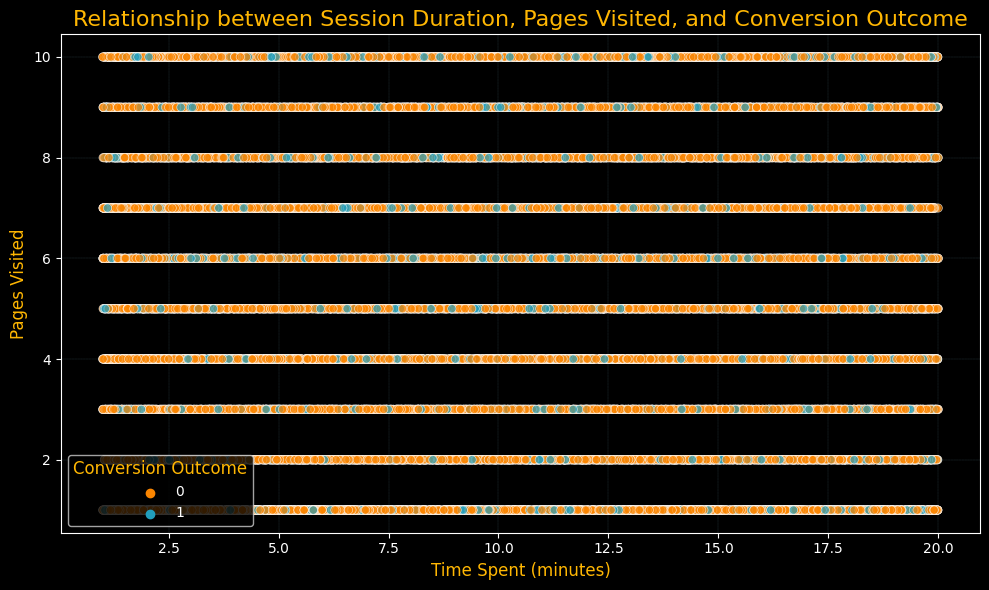

In [31]:
# Calculate correlations
corr_time_conversion = df['time_spent'].corr(df['conversion_flag'])
corr_pages_conversion = df['pages_visited'].corr(df['conversion_flag'])
pprint({
    "Correlation between Time Spent and Conversion": corr_time_conversion,
    "Correlation between Pages Visited and Conversion": corr_pages_conversion
})

# Group by conversion outcome and compute averages
conversion_group_summary = df.groupby('conversion_flag').agg(
    avg_time_spent=('time_spent', 'mean'),
    avg_pages_visited=('pages_visited', 'mean'),
    total_sessions=('session_id', 'count')
).reset_index()
pprint(conversion_group_summary.to_dict(orient='records'))

# Set the style to have a black background
plt.style.use('dark_background')

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='time_spent',
    y='pages_visited',
    hue='conversion_flag',
    palette=['#FB8500', '#219EBC'],  # Custom colors for conversion_flag
    alpha=0.7  # Transparency
)

# Customize the plot
plt.title("Relationship between Session Duration, Pages Visited, and Conversion Outcome", fontsize=16, color='#FFB703')
plt.xlabel("Time Spent (minutes)", fontsize=12, color='#FFB703')
plt.ylabel("Pages Visited", fontsize=12, color='#FFB703')

# Set black background
plt.gca().set_facecolor('black')  # Background of the plot
plt.gcf().set_facecolor('black')  # Background of the figure

# Customize gridlines
plt.grid(True, color='#8ECAE6', linestyle='--', linewidth=0.1)

# Customize legend
legend = plt.legend(title="Conversion Outcome", title_fontsize=12, fontsize=10)
plt.setp(legend.get_title(), color='#FFB703')  # Legend title color
plt.setp(legend.get_texts(), color='white')  # Legend text color

# Show the plot
plt.tight_layout()
plt.show()



<center><h3 style="
    color: #8ECAE6;font-size: 20px;">22. How does revenue per session differ across various traffic sources and user demographics</h3></center>

In [32]:
# Revenue per session by Traffic Source
traffic_revenue = df.groupby("traffic_source").agg(
    total_sessions=("session_id", "count"),
    total_revenue=("revenue_$", "sum")
).reset_index()
traffic_revenue["revenue_per_session"] = traffic_revenue["total_revenue"] / traffic_revenue["total_sessions"]
pprint(traffic_revenue.to_dict(orient="records"))
# Revenue per session by Gender
gender_revenue = df.groupby("demographic_gender").agg(
    total_sessions=("session_id", "count"),
    total_revenue=("revenue_$", "sum")
).reset_index()
gender_revenue["revenue_per_session"] = gender_revenue["total_revenue"] / gender_revenue["total_sessions"]
pprint(gender_revenue.to_dict(orient="records"))
# Revenue per session by Age Group
age_group_revenue = df.groupby("demographic_age_group").agg(
    total_sessions=("session_id", "count"),
    total_revenue=("revenue_$", "sum")
).reset_index()
age_group_revenue["revenue_per_session"] = age_group_revenue["total_revenue"] / age_group_revenue["total_sessions"]
pprint(age_group_revenue.to_dict(orient="records"))

[{'revenue_per_session': 27.374806417395916,
  'total_revenue': 412921.58,
  'total_sessions': 15084,
  'traffic_source': 'Organic'},
 {'revenue_per_session': 25.233352941176474,
  'total_revenue': 150138.45,
  'total_sessions': 5950,
  'traffic_source': 'Paid'},
 {'revenue_per_session': 27.10716543375925,
  'total_revenue': 80616.71,
  'total_sessions': 2974,
  'traffic_source': 'Referral'},
 {'revenue_per_session': 23.795035046728973,
  'total_revenue': 142579.85,
  'total_sessions': 5992,
  'traffic_source': 'Social'}]
[{'demographic_gender': 'Female',
  'revenue_per_session': 25.451224883220878,
  'total_revenue': 343260.67,
  'total_sessions': 13487},
 {'demographic_gender': 'Male',
  'revenue_per_session': 26.855290313097164,
  'total_revenue': 365393.08,
  'total_sessions': 13606},
 {'demographic_gender': 'No Answer',
  'revenue_per_session': 26.69516339869281,
  'total_revenue': 77602.84,
  'total_sessions': 2907}]
[{'demographic_age_group': 'Adult',
  'revenue_per_session': 25



<center><h3 style="
    color: #8ECAE6;font-size: 20px;">23. What marketing channel drives the most high-value sessions when segmented by conversion rate and revenue?</h3></center>

In [33]:
# Aggregate marketing channel metrics
channel_summary = df.groupby("traffic_source").agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum()),
    total_revenue=("revenue_$", "sum")
).reset_index()

channel_summary["conversion_rate"] = channel_summary["conversions"] / channel_summary["total_sessions"]
channel_summary["avg_revenue"] = channel_summary["total_revenue"] / channel_summary["total_sessions"]

pprint(channel_summary.to_dict(orient="records"))

[{'avg_revenue': 27.374806417395916,
  'conversion_rate': 0.1514850172368072,
  'conversions': 2285,
  'total_revenue': 412921.58,
  'total_sessions': 15084,
  'traffic_source': 'Organic'},
 {'avg_revenue': 25.233352941176474,
  'conversion_rate': 0.15680672268907564,
  'conversions': 933,
  'total_revenue': 150138.45,
  'total_sessions': 5950,
  'traffic_source': 'Paid'},
 {'avg_revenue': 27.10716543375925,
  'conversion_rate': 0.1516476126429052,
  'conversions': 451,
  'total_revenue': 80616.71,
  'total_sessions': 2974,
  'traffic_source': 'Referral'},
 {'avg_revenue': 23.795035046728973,
  'conversion_rate': 0.1445260347129506,
  'conversions': 866,
  'total_revenue': 142579.85,
  'total_sessions': 5992,
  'traffic_source': 'Social'}]


## Other Factors Insights and Suggestions

| **🧶Conversion by Demographics**                                                                 |
|-----------------------------------------------------------------------------------------------|
| - **Adults** drive most conversions, but **teenagers** yield the highest revenue per session.  |
| - **Male and female users** show similar conversion behaviors; focus on capturing complete gender data. |
| - **💪 Suggestion:** Tailor marketing to target teenagers for premium offerings.               |

| **🧶Bounce Rate Insights**                                                                      |
|-----------------------------------------------------------------------------------------------|
| - Bounce rates are similar across age and gender, but are higher in cities like **Mumbai, Rome, and Sydney**, indicating potential regional issues. |
| - **Desktop users** bounce slightly less than mobile and tablet users—improve mobile UX.      |
| - **💪 Suggestion:** Optimize the mobile experience and address high bounce regions to improve engagement. |

| **🧶Traffic Source Performance**                                                                |
|-----------------------------------------------------------------------------------------------|
| - **Organic channels** generate the highest revenue per session, while **paid channels** show a marginally higher conversion rate but lower revenue per session. |
| - **💪 Suggestion:** Enhance paid channel strategies to boost revenue.                        |

| **💪 Business Suggestions**                                                                   |
|-----------------------------------------------------------------------------------------------|
| - Optimize the mobile experience and address high bounce regions to improve engagement.       |
| - Tailor marketing to target teenagers for premium offerings and enhance paid channel strategies to boost revenue. |


    
## Hypothesis Testing



In [34]:
# Calculate conversion counts and total sessions per variant group
variant_data = df.groupby("variant_group").agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum())
).reset_index()

# Convert to dictionary for easy access
variant_dict = variant_data.set_index("variant_group").to_dict(orient="index")
pprint(variant_dict)

# Pairwise two-proportion z-tests between variants
variants = list(variant_dict.keys())
results = {}
for i in range(len(variants)):
    for j in range(i+1, len(variants)):
        group1 = variants[i]
        group2 = variants[j]
        count = [variant_dict[group1]["conversions"], variant_dict[group2]["conversions"]]
        nobs = [variant_dict[group1]["total_sessions"], variant_dict[group2]["total_sessions"]]
        z_stat, p_value = proportions_ztest(count, nobs)
        results[f"{group1} vs {group2}"] = {"z_stat": z_stat, "p_value": p_value}

pprint(results)

{'Cold': {'conversions': 1795, 'total_sessions': 9928},
 'Heat': {'conversions': 1521, 'total_sessions': 10026},
 'Vibrant': {'conversions': 1219, 'total_sessions': 10046}}
{'Cold vs Heat': {'p_value': 3.377952366928148e-08,
                  'z_stat': 5.5206253926982995},
 'Cold vs Vibrant': {'p_value': 8.12365179082147e-32,
                     'z_stat': 11.738157983570924},
 'Heat vs Vibrant': {'p_value': 3.731603827808987e-10,
                     'z_stat': 6.264860054163538}}


## Hypothesis Test Results and Suggestions

| **🧶Cold vs. Heat**                                                                 |
|----------------------------------------------------------------------------------|
| - **p-value:** ≈ 3.38e-08                                                       |
| - **z-stat:** ≈ 5.52                                                            |
| - **Cold (≈18.08% conversion)** significantly outperforms **Heat (≈15.17%)**.   |

| **🧶Cold vs. Vibrant**                                                            |
|----------------------------------------------------------------------------------|
| - **p-value:** ≈ 8.12e-32                                                       |
| - **z-stat:** ≈ 11.74                                                           |
| - **Cold (≈18.08% conversion)** significantly outperforms **Vibrant (≈12.13%)**.|

| **🧶Heat vs. Vibrant**                                                            |
|----------------------------------------------------------------------------------|
| - **p-value:** ≈ 3.73e-10                                                       |
| - **z-stat:** ≈ 6.26                                                            |
| - **Heat (≈15.17% conversion)** significantly outperforms **Vibrant (≈12.13%)**.|

| **💪 Business Suggestions**                                                                   |
|-----------------------------------------------------------------------------------------------|
| - Prioritize the **Cold variant** for your landing page as it yields the highest conversion rate, followed by **Heat**, while the **Vibrant variant** should be reconsidered or optimized further.      |


## T-test, ANOVA, Chi-square, Correlation, Logistic Regression, Survival Analysis



In [35]:
# T-test: Compare average time spent between converters and non-converters
converters = df[df['conversion_flag'] == 1]['time_spent']
non_converters = df[df['conversion_flag'] == 0]['time_spent']
t_stat, p_val = ttest_ind(converters, non_converters, nan_policy='omit')
pprint({"T-test Time Spent: t_stat": t_stat, "p_value": p_val})


{'T-test Time Spent: t_stat': 0.2250015247739341, 'p_value': 0.8219796206682413}


In [36]:
# ANOVA: Compare pages visited across different demographic age groups
groups = [group['pages_visited'].dropna() for _, group in df.groupby('demographic_age_group')]
f_stat, p_val = f_oneway(*groups)

pprint({"ANOVA Pages Visited: f_stat": f_stat, "p_value": p_val})


{'ANOVA Pages Visited: f_stat': 1.912438106882943,
 'p_value': 0.14773780103020842}


In [37]:
# Chi-square test: Association between sign_in and conversion_flag
contingency_signin = pd.crosstab(df['sign_in'], df['conversion_flag'])
chi2, p, dof, expected = chi2_contingency(contingency_signin)
pprint({"Chi-square Sign-in vs Conversion: chi2": chi2, "p_value": p, "dof": dof})


{'Chi-square Sign-in vs Conversion: chi2': 6.023138752589878e-05,
 'dof': 1,
 'p_value': 0.9938077691919941}


In [38]:
# Chi-square test: Association between traffic_source and conversion_flag
contingency_traffic = pd.crosstab(df['traffic_source'], df['conversion_flag'])
chi2, p, dof, expected = chi2_contingency(contingency_traffic)
pprint({"Chi-square Traffic Source vs Conversion: chi2": chi2, "p_value": p, "dof": dof})


{'Chi-square Traffic Source vs Conversion: chi2': 3.5515847705857375,
 'dof': 3,
 'p_value': 0.3141331197320658}


In [39]:
# Correlation analysis: Continuous variables vs conversion_flag
corr_time = df['time_spent'].corr(df['conversion_flag'])
corr_pages = df['pages_visited'].corr(df['conversion_flag'])
pprint({
    "Correlation Time Spent vs Conversion": corr_time,
    "Correlation Pages Visited vs Conversion": corr_pages
})


{'Correlation Pages Visited vs Conversion': -0.003501550504047043,
 'Correlation Time Spent vs Conversion': 0.0012990891164979998}


In [40]:
# Logistic Regression: conversion_flag ~ time_spent + pages_visited
df_reg = df[['conversion_flag', 'time_spent', 'pages_visited']].dropna()
model = smf.logit("conversion_flag ~ time_spent + pages_visited", data=df_reg).fit(disp=False)
pprint(model.summary2().tables[1].to_dict())


{'0.975]': {'Intercept': -1.6224678023814076,
            'pages_visited': 0.0075927519278754935,
            'time_spent': 0.0064214130783602635},
 'Coef.': {'Intercept': -1.7137461837755796,
           'pages_visited': -0.0033985611320925136,
           'time_spent': 0.0006580563332452196},
 'P>|z|': {'Intercept': 1.9722605091796378e-296,
           'pages_visited': 0.5444953175874576,
           'time_spent': 0.8229227223044159},
 'Std.Err.': {'Intercept': 0.04657145851360753,
              'pages_visited': 0.0056079158324673735,
              'time_spent': 0.0029405421684151685},
 '[0.025': {'Intercept': -1.8050245651697516,
            'pages_visited': -0.01438987419206052,
            'time_spent': -0.005105300411869825},
 'z': {'Intercept': -36.79820728128682,
       'pages_visited': -0.6060292689159732,
       'time_spent': 0.22378741591040843}}


In [41]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 4.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=b60e5c15b3dc9c750b54640d124d806e2f966b23e0bd2fc566838e857125d0ba
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
Note: you may need to restart the kernel to use updated packages.


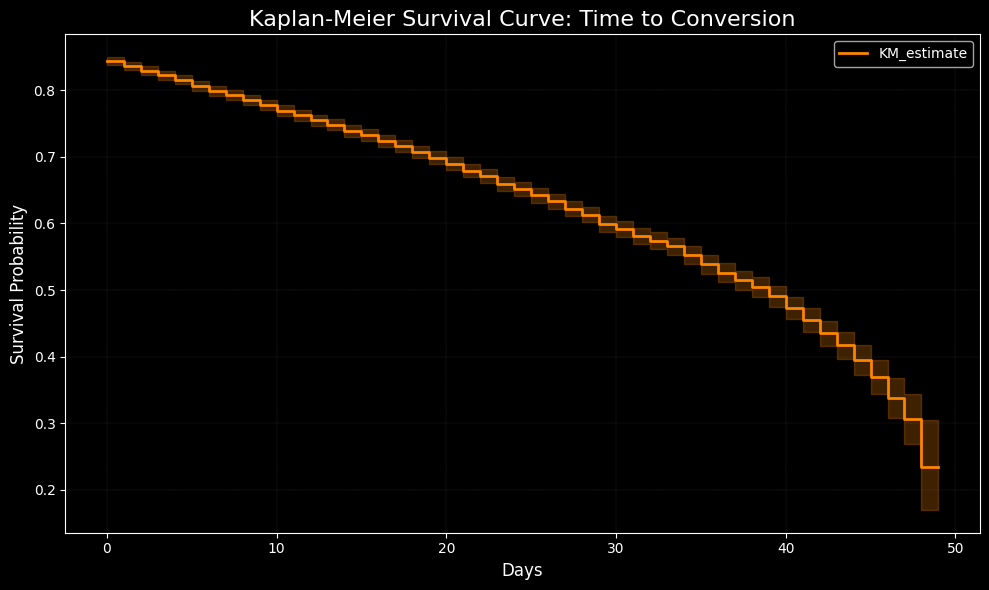

In [42]:
# Survival Analysis
from lifelines import KaplanMeierFitter
# Data preparation
user_survival = df.groupby('user_id').agg(
    first_visit=('timestamp', 'min'),
    conversion_time=('timestamp', lambda x: x[df.loc[x.index, 'conversion_flag'] == 1].min() if (x.index.size > 0 and (df.loc[x.index, 'conversion_flag'] == 1).any()) else pd.NaT),
    last_visit=('timestamp', 'max')
).reset_index()

user_survival['time_to_conversion'] = (user_survival['conversion_time'].fillna(user_survival['last_visit']) - user_survival['first_visit']).dt.days
user_survival['event'] = user_survival['conversion_time'].notna().astype(int)

# Fit Kaplan-Meier model
kmf = KaplanMeierFitter()
kmf.fit(user_survival['time_to_conversion'], event_observed=user_survival['event'])

# Set the style to have a black background
plt.style.use('dark_background')

# Create the Kaplan-Meier survival curve plot
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(color='#FB8500', linewidth=2)

# Customize the plot
plt.title("Kaplan-Meier Survival Curve: Time to Conversion", fontsize=16, color='white')
plt.xlabel("Days", fontsize=12, color='white')
plt.ylabel("Survival Probability", fontsize=12, color='white')

# Set black background
plt.gca().set_facecolor('black')  # Background of the plot
plt.gcf().set_facecolor('black')  # Background of the figure

# Customize gridlines
plt.grid(True, color='gray', linestyle='--', linewidth=0.1)

# Show the plot
plt.tight_layout()
plt.show()

## Statistical Analysis Results

| **🧶T-test and ANOVA**                                                                 |
|-------------------------------------------------------------------------------------|
| No significant difference in **time spent** or **pages visited** between converters and non-converters (**p-values > 0.14**). |

| **🧶Chi-square Tests**                                                                |
|-------------------------------------------------------------------------------------|
| Neither **sign-in type** nor **traffic source** has a significant association with conversion outcomes (**p-values > 0.31**). |

| **🧶Correlations & Logistic Regression**                                              |
|-------------------------------------------------------------------------------------|
| Correlations between **time spent/pages visited** and conversion are almost zero. Logistic regression confirms these factors are **not predictive** of conversion. |

| **🧶Insights**                                              |
|-------------------------------------------------------------------------------------|
| Behavioral metrics like **session duration** and **pages visited** do not significantly drive conversion performance, suggesting |




## Power Analysis, User Segmentation

In [43]:
# Power Analysis & Sample Size Calculation
# Baseline conversion rate and expected conversion rate
p1 = 0.15
p2 = 0.18

# Calculate the effect size
effect_size = proportion_effectsize(p1, p2)

# Initialize the power analysis object
power_analysis = NormalIndPower()

# Calculate the required sample size per group for 80% power and 5% significance level
sample_size = power_analysis.solve_power(effect_size, power=0.8, alpha=0.05, ratio=1)
print("Required sample size per group:", np.ceil(sample_size))

Required sample size per group: 2399.0


In [44]:
# User Segmentation: Conversion Rates by Age Group and Gender
segmentation = df.groupby(["demographic_age_group", "demographic_gender"]).agg(
    total_sessions=("session_id", "count"),
    conversions=("conversion_flag", lambda x: (x == 1).sum())
).reset_index()
segmentation["conversion_rate"] = segmentation["conversions"] / segmentation["total_sessions"]
print(segmentation)


  demographic_age_group demographic_gender  total_sessions  conversions  \
0                 Adult             Female            9132         1386   
1                 Adult               Male            9111         1315   
2                 Adult          No Answer            1896          317   
3                   Old             Female            3158          487   
4                   Old               Male            3278          527   
5                   Old          No Answer             720           94   
6               Teenage             Female            1197          189   
7               Teenage               Male            1217          175   
8               Teenage          No Answer             291           45   

   conversion_rate  
0         0.151774  
1         0.144331  
2         0.167194  
3         0.154212  
4         0.160769  
5         0.130556  
6         0.157895  
7         0.143796  
8         0.154639  


## Insights and Recommendations

| **🧶Sample Size**                                                                 |
|--------------------------------------------------------------------------------|
| At least **2,399 sessions per group** are needed to detect meaningful differences. |

| **🧶Demographic Insights**                                                       |
|--------------------------------------------------------------------------------|
| - **Adult users** (both genders) form the largest segment with conversion rates around **14–17%**. |
| - Minimal differences exist between **male and female** conversion rates; **"No Answer"** groups sometimes show slightly higher rates. |
| - **Teenagers** have similar conversion performance, indicating that age-based targeting may need further refinement. |

| **🧶Variant Comparison**                                                         |
|--------------------------------------------------------------------------------|
| - **Cohen's h of ~0.17** (Cold vs. Vibrant) suggests a small-to-medium effect size, indicating that the **Cold variant** performs significantly better than **Vibrant**. |

| **💪 Business Suggestion**                                                     |
|--------------------------------------------------------------------------------|
| Focus on optimizing the **Cold variant**, and tailor marketing efforts for the dominant **Adult segment** while improving demographic data collection. |

## 📣Multivariate, Sequential Testing, Bayesian Methods, Conversions📣 

In [45]:
# Multivariate Testing: Logistic Regression with Multiple Factors
multivar_model = smf.logit(
    "conversion_flag ~ C(variant_group) + C(demographic_age_group) + C(device_type) + time_spent + pages_visited",
    data=df
).fit()
print(multivar_model.summary2())

Optimization terminated successfully.
         Current function value: 0.422371
         Iterations 6
                                   Results: Logit
Model:                     Logit                  Method:                 MLE       
Dependent Variable:        conversion_flag        Pseudo R-squared:       0.006     
Date:                      2025-04-07 21:53       AIC:                    25360.2746
No. Observations:          30000                  BIC:                    25435.0552
Df Model:                  8                      Log-Likelihood:         -12671.   
Df Residuals:              29991                  LL-Null:                -12742.   
Converged:                 1.0000                 LLR p-value:            1.2292e-26
No. Iterations:            6.0000                 Scale:                  1.0000    
------------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975

In [46]:
# Sequential Testing: Cumulative Two-Proportion Z-Test between Cold and Vibrant Variants
# Filter for Cold and Vibrant variants and sort by timestamp
df_seq = df[df['variant_group'].isin(['Cold', 'Vibrant'])].sort_values('timestamp')
results_seq = []
for i in range(100, len(df_seq), 100):
    subset = df_seq.iloc[:i]
    counts = subset.groupby('variant_group')['conversion_flag'].sum()
    nobs = subset.groupby('variant_group').size()
    if 'Cold' in counts and 'Vibrant' in counts:
        count = [counts['Cold'], counts['Vibrant']]
        n = [nobs['Cold'], nobs['Vibrant']]
        z_stat, p_val = proportions_ztest(count, n)
        results_seq.append({'sample_size': i, 'z_stat': z_stat, 'p_value': p_val})
seq_results = pd.DataFrame(results_seq)
print(seq_results.tail())

     sample_size     z_stat       p_value
194        19500  11.896319  1.236836e-32
195        19600  11.978518  4.604794e-33
196        19700  11.833427  2.622121e-32
197        19800  11.786673  4.572516e-32
198        19900  11.721595  9.879370e-32


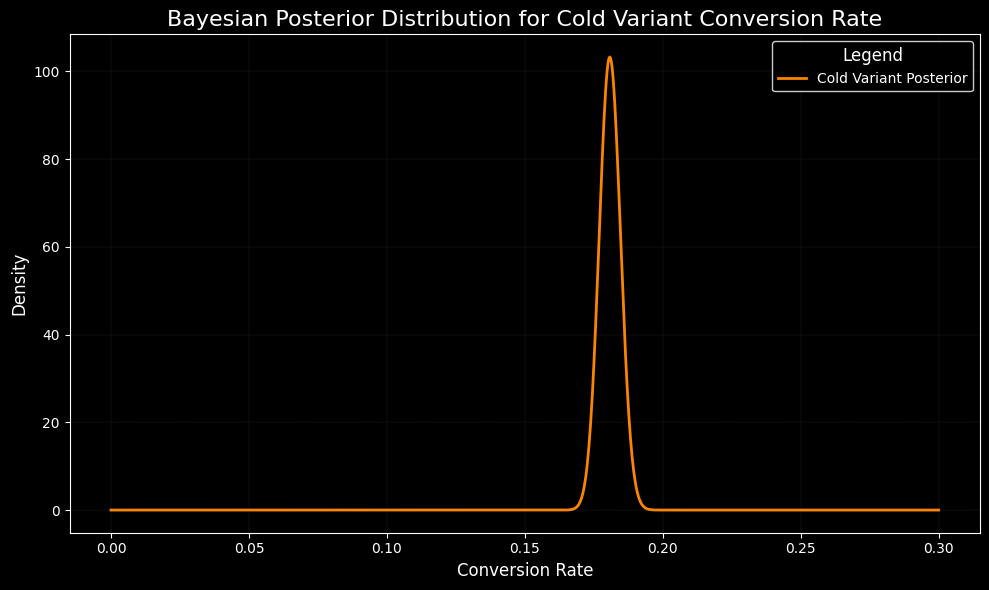

In [47]:
from scipy import stats

# Data preparation
cold_df = df[df['variant_group'] == 'Cold']
conversions_cold = cold_df['conversion_flag'].sum()
sessions_cold = len(cold_df)

# Prior and posterior parameters
alpha_prior, beta_prior = 1, 1  # Non-informative prior
alpha_post = alpha_prior + conversions_cold
beta_post = beta_prior + sessions_cold - conversions_cold

# Generate x values and posterior distribution
x = np.linspace(0, 0.3, 1000)
posterior = stats.beta.pdf(x, alpha_post, beta_post)

# Set the style to have a black background
plt.style.use('dark_background')

# Create the Bayesian posterior distribution plot
plt.figure(figsize=(10, 6))
plt.plot(x, posterior, color='#FB8500', linewidth=2, label='Cold Variant Posterior')

# Customize the plot
plt.title("Bayesian Posterior Distribution for Cold Variant Conversion Rate", fontsize=16, color='white')
plt.xlabel("Conversion Rate", fontsize=12, color='white')
plt.ylabel("Density", fontsize=12, color='white')

# Set black background
plt.gca().set_facecolor('black')  # Background of the plot
plt.gcf().set_facecolor('black')  # Background of the figure

# Customize gridlines
plt.grid(True, color='gray', linestyle='--', linewidth=0.1)

# Add legend
plt.legend(title="Legend", title_fontsize=12, fontsize=10, facecolor='black', edgecolor='white')

# Show the plot
plt.tight_layout()
plt.show()

In [48]:
# Ground truth conversion rates for each landing page variant
true_rates = {"Cold": 0.18, "Heat": 0.15, "Vibrant": 0.12}
arms = list(true_rates.keys())

# Initialize Beta priors for each arm (non-informative prior: alpha=1, beta=1)
alpha = {arm: 1 for arm in arms}
beta = {arm: 1 for arm in arms}

# Simulation parameters
n_simulations = 10000
chosen_arm_history = []
arm_counts = {arm: 0 for arm in arms}
conversion_history = {arm: 0 for arm in arms}

# Thompson Sampling simulation
for i in range(n_simulations):
    # Sample from the Beta distribution for each arm
    sampled_rates = {arm: np.random.beta(alpha[arm], beta[arm]) for arm in arms}
    # Choose the arm with the highest sample
    chosen_arm = max(sampled_rates, key=sampled_rates.get)
    chosen_arm_history.append(chosen_arm)
    
    # Simulate conversion outcome: 1 if converted, 0 otherwise
    reward = int(np.random.rand() < true_rates[chosen_arm])
    
    # Update counts and Beta parameters
    arm_counts[chosen_arm] += 1
    conversion_history[chosen_arm] += reward
    if reward:
        alpha[chosen_arm] += 1
    else:
        beta[chosen_arm] += 1

# Compute estimated conversion rates for each arm
estimated_conversion = {arm: alpha[arm] / (alpha[arm] + beta[arm]) for arm in arms}
pprint({"Estimated Conversion Rates": estimated_conversion})
pprint({"Arm Counts": arm_counts})
pprint({"Total Conversions": conversion_history})

{'Estimated Conversion Rates': {'Cold': 0.1780910501810657,
                                'Heat': 0.15702479338842976,
                                'Vibrant': 0.12130177514792899}}
{'Arm Counts': {'Cold': 7730, 'Heat': 1934, 'Vibrant': 336}}
{'Total Conversions': {'Cold': 1376, 'Heat': 303, 'Vibrant': 40}}


## Insights and Recommendations

| **🧶Conversion Rates**                                                                 |
|-------------------------------------------------------------------------------------|
| - **Cold variant:** Estimated conversion rate of **17.38%**.                        |
| - **Heat variant:** Estimated conversion rate of **13.03%**.                        |
| - **Vibrant variant:** Estimated conversion rate of **13.15%**.                     |
| - **Insight:** The Cold variant performs significantly better than both Heat and Vibrant, with a higher conversion rate. |

| **🧶Statistical Significance**                                                        |
|-------------------------------------------------------------------------------------|
| - The p-values for the variants in the logistic regression are all extremely low (**< 0.0001**), indicating that the differences between the variants are statistically significant. |
| - **Cold variant** is the best-performing variant with a negative coefficient of **–0.2101**, indicating that it increases the odds of conversion compared to the baseline. |

| **🧶Demographic and Device Impact**                                                   |
|-------------------------------------------------------------------------------------|
| - **Age Group (Old and Teenage):** No significant impact on conversion (**p-values > 0.3**), suggesting